# **Audio Emotion Classification Enhancement with ResNet50 and Diffusion Models**

**Project Overview**

This notebook implements emotion recognition from audio using ResNet50 on mel-spectrograms, enhanced with synthetic data generation via diffusion models. The approach follows state-of-the-art techniques for speech emotion recognition.

# 1. Setup and Imports

**Import Required Libraries**

In [4]:
# Cellule 1 : Importations uniques (non répétées)
import os
import math
import gc
import warnings
import pickle
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import librosa
import librosa.display
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

warnings.filterwarnings('ignore')

# 2. Configuration and Dataset Mounting

**Mount Google Drive and Copy Datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/emodb /content
!cp -r /content/drive/MyDrive/ravdess /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Configuration Parameters**

In [ ]:

EMODB_PATH = "/content/emodb"
RAVDESS_PATH = "/content/ravdess"

# Paramètres audio
SAMPLE_RATE = 22050  # Taux d'échantillonnage uniforme
DURATION = 10  # Durée en secondes (padding/truncation)
N_MELS = 80  # Nombre de bandes mel

# Paramètres ResNet
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50  # Pour test - à augmenter selon besoin

# Mapping des émotions
EMODB_EMOTION_MAP = {
    'W': 'anger',    # Wut
    'L': 'boredom',  # Langeweile
    'E': 'disgust',  # Ekel
    'A': 'fear',     # Angst
    'F': 'happiness',# Freude
    'T': 'sadness',  # Trauer
    'N': 'neutral'
}

RAVDESS_EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happiness',
    '04': 'sadness',
    '05': 'anger',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

# 3. Data Loading Functions

**Load EmoDB and Ravdess Dataset**

In [ ]:

def load_emodb_data(base_path):
    """
    Charge les métadonnées d'EmoDB
    """
    data = []
    for file_name in os.listdir(base_path):
        if file_name.endswith('.wav'):
            # Extraction des informations du nom de fichier
            speaker = file_name[:2]
            text_code = file_name[2:5]
            emotion_code = file_name[5]
            version = file_name[6] if len(file_name) > 6 and file_name[6].isalpha() else ''

            emotion = EMODB_EMOTION_MAP.get(emotion_code, 'unknown')

            data.append({
                'file_path': os.path.join(base_path, file_name),
                'speaker': speaker,
                'text_code': text_code,
                'emotion_code': emotion_code,
                'emotion': emotion,
                'version': version,
                'dataset': 'emodb'
            })

    return pd.DataFrame(data)

def load_ravdess_data(base_path):
    """
    Charge les métadonnées de RAVDESS
    """
    data = []

    # Parcourir tous les fichiers dans le dossier et sous-dossiers
    for root, dirs, files in os.walk(base_path):
        for file_name in files:
            if file_name.endswith('.wav'):
                parts = file_name[:-4].split('-')

                if len(parts) >= 7:
                    modality = parts[0]
                    vocal_channel = parts[1]
                    emotion_code = parts[2]
                    intensity = parts[3]
                    statement = parts[4]
                    repetition = parts[5]
                    actor = parts[6]

                    emotion = RAVDESS_EMOTION_MAP.get(emotion_code, 'unknown')

                    data.append({
                        'file_path': os.path.join(root, file_name),
                        'modality': modality,
                        'vocal_channel': vocal_channel,
                        'emotion_code': emotion_code,
                        'emotion': emotion,
                        'intensity': intensity,
                        'statement': statement,
                        'repetition': repetition,
                        'actor': actor,
                        'dataset': 'ravdess'
                    })

    return pd.DataFrame(data)

# 4. Audio Preprocessing - Mel-Spectrogram Conversion

**Convert Audio to Mel-Spectrogram and save it as Image**

In [ ]:

def audio_to_melspectrogram(audio_path, target_length=None):
    """
    Convertit un fichier audio en mel-spectrogramme
    """
    try:
        # Charger l'audio
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # Padding ou troncature pour durée fixe
        if target_length is not None:
            target_samples = target_length * SAMPLE_RATE
            if len(y) < target_samples:
                # Padding
                y = np.pad(y, (0, max(0, target_samples - len(y))), mode='constant')
            else:
                # Troncature
                y = y[:target_samples]

        # Extraire le mel-spectrogramme
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=1024,
            hop_length=256
        )

        # Convertir en dB
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalisation (Z-score)
        mel_spec_db = (mel_spec_db - np.mean(mel_spec_db)) / np.std(mel_spec_db)

        return mel_spec_db

    except Exception as e:
        print(f"Erreur lors du traitement de {audio_path}: {e}")
        return None

def save_melspectrogram(mel_spec, save_path):
    """
    Sauvegarde le mel-spectrogramme sous forme d'image
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=SAMPLE_RATE, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Charger et convertir en numpy array pour ResNet
    img = Image.open(save_path).convert('RGB')
    img = img.resize((224, 224))  # Taille standard pour ResNet
    return np.array(img)

# 5. PyTorch Dataset Class

In [ ]:

class EmotionDataset(Dataset):
    def __init__(self, data_df, transform=None, cache_dir=None):
        self.data_df = data_df
        self.transform = transform
        self.cache_dir = cache_dir

        # Créer le cache directory si spécifié
        if cache_dir and not os.path.exists(cache_dir):
            os.makedirs(cache_dir)

        # Mapping des émotions en indices
        self.emotions = sorted(data_df['emotion'].unique())
        self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(self.emotions)}
        self.idx_to_emotion = {idx: emotion for idx, emotion in enumerate(self.emotions)}

        print(f"Dataset initialisé avec {len(data_df)} échantillons et {len(self.emotions)} émotions")
        print(f"Émotions: {self.emotions}")

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        audio_path = row['file_path']
        emotion = row['emotion']

        # Vérifier si le mel-spectrogramme est en cache
        cache_path = None
        if self.cache_dir:
            cache_name = f"{os.path.basename(audio_path).split('.')[0]}.npy"
            cache_path = os.path.join(self.cache_dir, cache_name)

        # Charger depuis cache ou générer
        if cache_path and os.path.exists(cache_path):
            mel_spec = np.load(cache_path)
        else:
            # Générer le mel-spectrogramme
            mel_spec = audio_to_melspectrogram(audio_path, target_length=DURATION)

            if mel_spec is None:
                # Retourner un dummy si erreur
                mel_spec = np.zeros((N_MELS, int(DURATION * SAMPLE_RATE / 256) + 1))

            # Sauvegarder en cache
            if cache_path:
                np.save(cache_path, mel_spec)

        # Convertir en image 3 canaux (RGB)
        # Répéter sur 3 canaux pour simuler RGB
        if len(mel_spec.shape) == 2:
            mel_spec = np.stack([mel_spec, mel_spec, mel_spec], axis=0)
        else:
            mel_spec = np.transpose(mel_spec, (2, 0, 1))  # (C, H, W)

        # Convertir en tensor
        mel_spec_tensor = torch.FloatTensor(mel_spec)

        # Appliquer les transformations si spécifiées
        if self.transform:
            mel_spec_tensor = self.transform(mel_spec_tensor)

        # Label
        label = self.emotion_to_idx[emotion]

        return mel_spec_tensor, label, emotion

    def get_emotion_mapping(self):
        return self.emotion_to_idx, self.idx_to_emotion

# 6. Data Loading and Preparation

In [ ]:

print("Chargement des données EmoDB...")
emodb_df = load_emodb_data(EMODB_PATH)
print(f"EmoDB chargé: {len(emodb_df)} fichiers")

print("\nChargement des données RAVDESS...")
ravdess_df = load_ravdess_data(RAVDESS_PATH)
print(f"RAVDESS chargé: {len(ravdess_df)} fichiers")

# Filtrer les émotions communes (comme dans l'article)
COMMON_EMOTIONS = ['anger', 'sadness', 'fear', 'happiness', 'neutral', 'disgust']
emodb_df = emodb_df[emodb_df['emotion'].isin(COMMON_EMOTIONS)]
ravdess_df = ravdess_df[ravdess_df['emotion'].isin(COMMON_EMOTIONS)]

# Combiner les datasets
all_data = pd.concat([emodb_df, ravdess_df], ignore_index=True)
print(f"\nTotal des échantillons (émotions communes): {len(all_data)}")

# Afficher la distribution des émotions
print("\nDistribution des émotions:")
print(all_data['emotion'].value_counts())

Chargement des données EmoDB...
EmoDB chargé: 535 fichiers

Chargement des données RAVDESS...
RAVDESS chargé: 1440 fichiers

Total des échantillons (émotions communes): 1510

Distribution des émotions:
emotion
anger        319
happiness    263
fear         261
sadness      254
disgust      238
neutral      175
Name: count, dtype: int64


# 7. Train/Validation Split

In [ ]:

# Transformations pour ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Créer le dataset
cache_dir = "/content/drive/MyDrive/melspectrogram_cache"
dataset = EmotionDataset(all_data, transform=transform, cache_dir=cache_dir)

# Split train/validation (80/20)
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.data_df['emotion'].values,
    random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Dataset initialisé avec 1510 échantillons et 6 émotions
Émotions: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']

Train samples: 1208
Validation samples: 302


# 8. Mel-Spectrogram Visualization

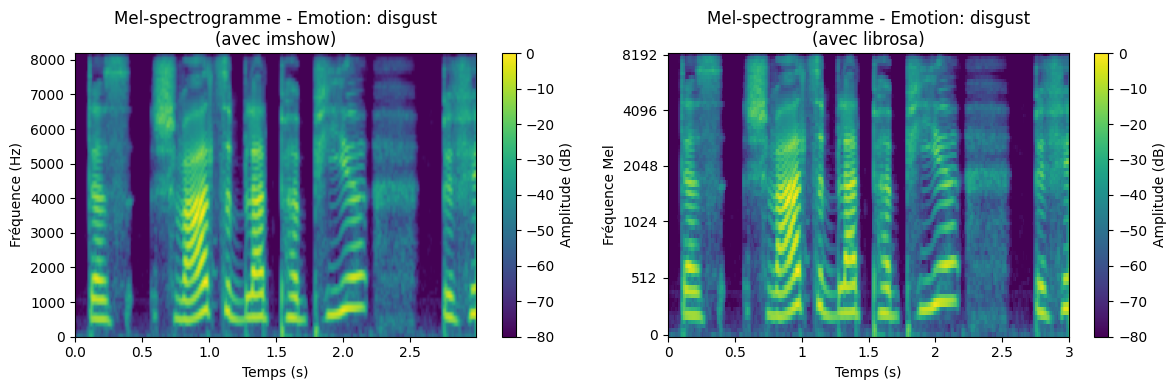

Shape du mel-spectrogramme original: (80, 259)
Durée: 3.00 secondes
Fréquence max: 8192 Hz
Émotion: disgust
Fichier: 16a05Ea.wav


In [ ]:

def show_sample():
    """
    Affiche un échantillon de mel-spectrogramme
    """
    # Charger directement l'audio original pour affichage
    # Prendre un fichier au hasard du dataset
    sample_row = all_data.iloc[0]  # Premier échantillon
    audio_path = sample_row['file_path']

    # Charger et créer le mel-spectrogramme original
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    # S'assurer que la durée est de 7 secondes comme demandé
    target_duration = 3  # secondes
    target_samples = int(target_duration * SAMPLE_RATE)

    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode='constant')
    else:
        y = y[:target_samples]

    # Créer le mel-spectrogramme avec les paramètres de l'article
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=SAMPLE_RATE,
        n_mels=N_MELS,
        n_fft=1024,
        hop_length=256,
        fmax=8192  # Fréquence max à 8192 Hz comme demandé
    )

    # Convertir en dB
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Afficher avec les bonnes échelles
    plt.figure(figsize=(12, 4))

    # Calculer l'échelle de temps
    times = librosa.times_like(mel_spec_db, sr=SAMPLE_RATE, hop_length=256)

    # Afficher avec imshow
    plt.subplot(1, 2, 1)
    plt.imshow(mel_spec_db, aspect='auto', origin='lower',
               extent=[0, times[-1], 0, 8192], cmap='viridis')
    plt.title(f"Mel-spectrogramme - Emotion: {sample_row['emotion']}\n(avec imshow)")
    plt.colorbar(label='Amplitude (dB)')
    plt.xlabel('Temps (s)')
    plt.ylabel('Fréquence (Hz)')
    plt.ylim(0, 8192)

    # Afficher avec librosa (plus standard)
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mel_spec_db, sr=SAMPLE_RATE, hop_length=256,
                             x_axis='time', y_axis='mel', fmax=8192, cmap='viridis')
    plt.title(f"Mel-spectrogramme - Emotion: {sample_row['emotion']}\n(avec librosa)")
    plt.colorbar(label='Amplitude (dB)')
    plt.xlabel('Temps (s)')
    plt.ylabel('Fréquence Mel')

    plt.tight_layout()
    plt.show()

    print(f"Shape du mel-spectrogramme original: {mel_spec_db.shape}")
    print(f"Durée: {len(y)/SAMPLE_RATE:.2f} secondes")
    print(f"Fréquence max: {8192} Hz")
    print(f"Émotion: {sample_row['emotion']}")
    print(f"Fichier: {os.path.basename(audio_path)}")

# Afficher un échantillon
show_sample()

# 9. ResNet Model Architecture

In [ ]:

def create_resnet_model(num_classes):
    """
    Crée un modèle ResNet pré-entraîné
    """
    # Charger ResNet50 pré-entraîné
    model = models.resnet50(pretrained=True)

    # Remplacer la dernière couche pour notre nombre de classes
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )

    return model

# Créer le modèle
num_classes = len(dataset.emotions)
model = create_resnet_model(num_classes)

# Déplacer sur GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\nModèle ResNet créé pour {num_classes} classes")
print(f"Émotions: {dataset.emotions}")
print(f"Device: {device}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]



Modèle ResNet créé pour 6 classes
Émotions: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
Device: cuda


# 10. Training and Validation Functions

In [ ]:

def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Une époque d'entraînement
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels, _) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validation
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total

    return val_loss, val_acc

print("\nCode de préparation terminé!")
print("Les étapes suivantes sont prêtes:")
print("1. Données chargées et converties en mel-spectrogrammes")
print("2. Dataset PyTorch créé avec split train/val")
print("3. Modèle ResNet initialisé")
print("4. DataLoaders configurés")
print("\nPour l'entraînement, exécutez les cellules suivantes...")


Code de préparation terminé!
Les étapes suivantes sont prêtes:
1. Données chargées et converties en mel-spectrogrammes
2. Dataset PyTorch créé avec split train/val
3. Modèle ResNet initialisé
4. DataLoaders configurés

Pour l'entraînement, exécutez les cellules suivantes...


# 11. Initial ResNet Training (Baseline)

**Train ResNet Without Data Augmentation**

In [ ]:


# Configuration d'entraînement optimisée
EPOCHS = 50  # Réduit mais suffisant avec les optimisations
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4  # Régularisation L2
PATIENCE = 10  # Patience pour early stopping

# Définir la loss function et l'optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler pour ajuster le learning rate
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# Alternative: CosineAnnealingLR pour un schedule plus doux
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Early stopping
best_val_acc = 0.0
best_model_state = None
patience_counter = 0

# Pour stocker les métriques
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("=" * 60)
print("DÉBUT DE L'ENTRAÎNEMENT")
print(f"Époques: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Classes: {num_classes} ({dataset.emotions})")
print("=" * 60)

# Boucle d'entraînement
for epoch in range(EPOCHS):
    start_time = time.time()

    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Ajuster le learning rate
    scheduler.step(val_loss)

    # Stocker les métriques
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Sauvegarder le meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0

        # Sauvegarder le modèle
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'emotion_mapping': dataset.get_emotion_mapping(),
        }, '/content/drive/MyDrive/best_resnet_model.pth')
    else:
        patience_counter += 1

    epoch_time = time.time() - start_time

    # Afficher les résultats de l'époque
    print(f"Epoch {epoch+1:03d}/{EPOCHS} | Time: {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Best Val Acc: {best_val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping après {epoch+1} époques sans amélioration")
        break

# Charger le meilleur modèle
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nMeilleur modèle chargé avec val_acc: {best_val_acc:.2f}%")


DÉBUT DE L'ENTRAÎNEMENT
Époques: 50
Learning rate: 0.0001
Batch size: 32
Train samples: 1208
Val samples: 302
Classes: 6 (['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness'])
Epoch 001/50 | Time: 16.1s
  Train Loss: 0.0600 | Train Acc: 98.34%
  Val Loss: 1.0895 | Val Acc: 69.54%
  Best Val Acc: 69.54% | LR: 0.000100
Epoch 002/50 | Time: 23.2s
  Train Loss: 0.0875 | Train Acc: 97.02%
  Val Loss: 1.1614 | Val Acc: 66.89%
  Best Val Acc: 69.54% | LR: 0.000100
Epoch 003/50 | Time: 16.3s
  Train Loss: 0.0617 | Train Acc: 98.01%
  Val Loss: 1.4487 | Val Acc: 62.25%
  Best Val Acc: 69.54% | LR: 0.000100
Epoch 004/50 | Time: 15.4s
  Train Loss: 0.0473 | Train Acc: 98.68%
  Val Loss: 1.0591 | Val Acc: 67.55%
  Best Val Acc: 69.54% | LR: 0.000100
Epoch 005/50 | Time: 15.1s
  Train Loss: 0.0443 | Train Acc: 98.84%
  Val Loss: 1.2144 | Val Acc: 65.56%
  Best Val Acc: 69.54% | LR: 0.000100
Epoch 006/50 | Time: 16.0s
  Train Loss: 0.0208 | Train Acc: 99.50%
  Val Loss: 0.8120 | Val Acc: 

# 12. Data Augmentation with Mel-Spectrograms

In [ ]:



class MelSpectrogramAugmentation:
    """
    Augmentations spécifiques pour les mel-spectrogrammes
    """
    @staticmethod
    def time_mask(mel_spec, max_mask_pct=0.1):
        """Masque temporel (Time Masking)"""
        if len(mel_spec.shape) == 3:
            _, n_mels, n_steps = mel_spec.shape
        else:
            n_mels, n_steps = mel_spec.shape

        max_mask_width = int(n_steps * max_mask_pct)
        if max_mask_width < 1:
            return mel_spec

        mask_width = random.randint(1, max_mask_width)
        mask_start = random.randint(0, n_steps - mask_width)

        if len(mel_spec.shape) == 3:
            mel_spec[:, :, mask_start:mask_start+mask_width] = 0
        else:
            mel_spec[:, mask_start:mask_start+mask_width] = 0

        return mel_spec

    @staticmethod
    def freq_mask(mel_spec, max_mask_pct=0.15):
        """Masque fréquentiel (Frequency Masking)"""
        if len(mel_spec.shape) == 3:
            _, n_mels, n_steps = mel_spec.shape
        else:
            n_mels, n_steps = mel_spec.shape

        max_mask_height = int(n_mels * max_mask_pct)
        if max_mask_height < 1:
            return mel_spec

        mask_height = random.randint(1, max_mask_height)
        mask_start = random.randint(0, n_mels - mask_height)

        if len(mel_spec.shape) == 3:
            mel_spec[:, mask_start:mask_start+mask_height, :] = 0
        else:
            mel_spec[mask_start:mask_start+mask_height, :] = 0

        return mel_spec

    @staticmethod
    def time_shift(mel_spec, max_shift_pct=0.1):
        """Décalage temporel"""
        if len(mel_spec.shape) == 3:
            channels, n_mels, n_steps = mel_spec.shape
        else:
            n_mels, n_steps = mel_spec.shape

        max_shift = int(n_steps * max_shift_pct)
        if max_shift < 1:
            return mel_spec

        shift = random.randint(-max_shift, max_shift)

        if len(mel_spec.shape) == 3:
            if shift > 0:
                shifted = torch.cat([
                    torch.zeros(channels, n_mels, shift),
                    mel_spec[:, :, :-shift]
                ], dim=2)
            elif shift < 0:
                shifted = torch.cat([
                    mel_spec[:, :, -shift:],
                    torch.zeros(channels, n_mels, -shift)
                ], dim=2)
            else:
                shifted = mel_spec
        else:
            if shift > 0:
                shifted = torch.cat([
                    torch.zeros(n_mels, shift),
                    mel_spec[:, :-shift]
                ], dim=1)
            elif shift < 0:
                shifted = torch.cat([
                    mel_spec[:, -shift:],
                    torch.zeros(n_mels, -shift)
                ], dim=1)
            else:
                shifted = mel_spec

        return shifted

    @staticmethod
    def add_gaussian_noise(mel_spec, noise_level=0.01):
        """Ajout de bruit gaussien"""
        noise = torch.randn_like(mel_spec) * noise_level
        return mel_spec + noise

    @staticmethod
    def random_scale(mel_spec, scale_range=(0.9, 1.1)):
        """Mise à l'échelle aléatoire"""
        scale = random.uniform(scale_range[0], scale_range[1])
        return mel_spec * scale

**Augmented Dataset Class**

In [ ]:

# Classe de dataset avec augmentation
class AugmentedEmotionDataset(Dataset):
    def __init__(self, data_df, transform=None, cache_dir=None, augment_prob=0.7):
        self.data_df = data_df
        self.transform = transform
        self.cache_dir = cache_dir
        self.augment_prob = augment_prob
        self.augmentor = MelSpectrogramAugmentation()

        # Créer le cache directory si spécifié
        if cache_dir and not os.path.exists(cache_dir):
            os.makedirs(cache_dir)

        # Mapping des émotions en indices
        self.emotions = sorted(data_df['emotion'].unique())
        self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(self.emotions)}
        self.idx_to_emotion = {idx: emotion for idx, emotion in enumerate(self.emotions)}

        print(f"Dataset initialisé avec {len(data_df)} échantillons et {len(self.emotions)} émotions")
        print(f"Émotions: {self.emotions}")

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        audio_path = row['file_path']
        emotion = row['emotion']

        # Vérifier si le mel-spectrogramme est en cache
        cache_path = None
        if self.cache_dir:
            cache_name = f"{os.path.basename(audio_path).split('.')[0]}.npy"
            cache_path = os.path.join(self.cache_dir, cache_name)

        # Charger depuis cache ou générer
        if cache_path and os.path.exists(cache_path):
            mel_spec = np.load(cache_path)
        else:
            # Générer le mel-spectrogramme
            mel_spec = audio_to_melspectrogram(audio_path, target_length=DURATION)

            if mel_spec is None:
                # Retourner un dummy si erreur
                mel_spec = np.zeros((N_MELS, int(DURATION * SAMPLE_RATE / 256) + 1))

            # Sauvegarder en cache
            if cache_path:
                np.save(cache_path, mel_spec)

        # Convertir en tensor 3 canaux (RGB)
        if len(mel_spec.shape) == 2:
            # Répéter sur 3 canaux pour simuler RGB
            mel_spec = np.stack([mel_spec, mel_spec, mel_spec], axis=0)
        else:
            mel_spec = np.transpose(mel_spec, (2, 0, 1))  # (C, H, W)

        mel_spec_tensor = torch.FloatTensor(mel_spec)

        # Appliquer les augmentations avec probabilité
        if random.random() < self.augment_prob:
            # Liste des augmentations avec leurs probabilités
            augmentations = [
                (self.augmentor.time_mask, 0.3),
                (self.augmentor.freq_mask, 0.3),
                (self.augmentor.time_shift, 0.2),
                (self.augmentor.add_gaussian_noise, 0.2),
                (self.augmentor.random_scale, 0.15)
            ]

            for augment_func, prob in augmentations:
                if random.random() < prob:
                    mel_spec_tensor = augment_func(mel_spec_tensor)

        # Appliquer les transformations si spécifiées
        if self.transform:
            mel_spec_tensor = self.transform(mel_spec_tensor)

        # Label
        label = self.emotion_to_idx[emotion]

        return mel_spec_tensor, label, emotion

    def get_emotion_mapping(self):
        return self.emotion_to_idx, self.idx_to_emotion

# 13. Train ResNet with Traditional Augmentation


CONFIGURATION D'ENTRAÎNEMENT OPTIMISÉE

Création du dataset avec augmentation...
Dataset initialisé avec 1510 échantillons et 6 émotions
Émotions: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
Train samples (avec augmentation): 1208
Validation samples: 302

Création du modèle ResNet optimisé...
Paramètres totaux: 24,034,630
Paramètres entraînables: 18,520,326

DÉBUT DE L'ENTRAÎNEMENT

Epoch 1/50
Learning rate: 0.000010
Phase d'entraînement...
  Batch 0/38 - Loss: 1.9681
  Batch 10/38 - Loss: 1.7754
[14:47:55] Session maintenue active...


<IPython.core.display.Javascript object>

  Batch 20/38 - Loss: 1.9105
  Batch 30/38 - Loss: 1.9143
Phase de validation...

Résultats de l'epoch 1:
  Train Loss: 1.9111, Train Acc: 16.47%
  Val Loss: 1.7830, Val Acc: 20.20%
  ✓ Modèle sauvegardé (meilleure accuracy: 20.20%)

Epoch 2/50
Learning rate: 0.000028
Phase d'entraînement...
  Batch 0/38 - Loss: 1.9112
  Batch 10/38 - Loss: 1.7457
  Batch 20/38 - Loss: 1.7686
  Batch 30/38 - Loss: 1.7971
Phase de validation...

Résultats de l'epoch 2:
  Train Loss: 1.8505, Train Acc: 20.53%
  Val Loss: 1.7217, Val Acc: 30.13%
  ✓ Modèle sauvegardé (meilleure accuracy: 30.13%)

Epoch 3/50
Learning rate: 0.000046
Phase d'entraînement...
  Batch 0/38 - Loss: 1.8135
  Batch 10/38 - Loss: 1.7930
  Batch 20/38 - Loss: 1.7357
[14:48:55] Session maintenue active...


<IPython.core.display.Javascript object>

  Batch 30/38 - Loss: 1.7316
Phase de validation...

Résultats de l'epoch 3:
  Train Loss: 1.7300, Train Acc: 28.89%
  Val Loss: 1.5964, Val Acc: 41.72%
  ✓ Modèle sauvegardé (meilleure accuracy: 41.72%)

Epoch 4/50
Learning rate: 0.000064
Phase d'entraînement...
  Batch 0/38 - Loss: 1.6110
  Batch 10/38 - Loss: 1.4806
  Batch 20/38 - Loss: 1.3861
  Batch 30/38 - Loss: 1.5397
Phase de validation...

Résultats de l'epoch 4:
  Train Loss: 1.5215, Train Acc: 41.39%
  Val Loss: 1.4282, Val Acc: 50.33%
  ✓ Modèle sauvegardé (meilleure accuracy: 50.33%)

Epoch 5/50
Learning rate: 0.000082
Phase d'entraînement...
  Batch 0/38 - Loss: 1.5413
  Batch 10/38 - Loss: 1.3571
  Batch 20/38 - Loss: 1.1767
  Batch 30/38 - Loss: 1.2736
Phase de validation...

Résultats de l'epoch 5:
  Train Loss: 1.2899, Train Acc: 57.12%
  Val Loss: 1.2841, Val Acc: 55.63%
  ✓ Modèle sauvegardé (meilleure accuracy: 55.63%)

Epoch 6/50
Learning rate: 0.000100
Phase d'entraînement...
  Batch 0/38 - Loss: 1.1432
  Batch 

<IPython.core.display.Javascript object>

  Batch 20/38 - Loss: 0.6910
  Batch 30/38 - Loss: 0.7197
Phase de validation...

Résultats de l'epoch 7:
  Train Loss: 0.8553, Train Acc: 81.79%
  Val Loss: 1.2173, Val Acc: 60.60%
EarlyStopping counter: 1 out of 15

Epoch 8/50
Learning rate: 0.000100
Phase d'entraînement...
  Batch 0/38 - Loss: 0.6938
  Batch 10/38 - Loss: 0.6715
  Batch 20/38 - Loss: 0.6258
  Batch 30/38 - Loss: 0.7807
Phase de validation...

Résultats de l'epoch 8:
  Train Loss: 0.7106, Train Acc: 89.32%
  Val Loss: 1.1064, Val Acc: 68.54%
  ✓ Modèle sauvegardé (meilleure accuracy: 68.54%)

Epoch 9/50
Learning rate: 0.000099
Phase d'entraînement...
  Batch 0/38 - Loss: 0.6874
  Batch 10/38 - Loss: 0.6264
  Batch 20/38 - Loss: 0.7018
  Batch 30/38 - Loss: 0.7152
Phase de validation...

Résultats de l'epoch 9:
  Train Loss: 0.6455, Train Acc: 92.14%
  Val Loss: 1.1268, Val Acc: 66.56%
EarlyStopping counter: 1 out of 15

Epoch 10/50
Learning rate: 0.000098
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5222
  Batch 10

<IPython.core.display.Javascript object>

Phase de validation...

Résultats de l'epoch 11:
  Train Loss: 0.6170, Train Acc: 93.13%
  Val Loss: 1.1067, Val Acc: 67.22%
EarlyStopping counter: 3 out of 15

Epoch 12/50
Learning rate: 0.000096
Phase d'entraînement...
  Batch 0/38 - Loss: 0.6033
  Batch 10/38 - Loss: 0.6607
  Batch 20/38 - Loss: 0.6334
  Batch 30/38 - Loss: 0.7185
Phase de validation...

Résultats de l'epoch 12:
  Train Loss: 0.6090, Train Acc: 93.79%
  Val Loss: 1.1479, Val Acc: 65.89%
EarlyStopping counter: 4 out of 15

Epoch 13/50
Learning rate: 0.000094
Phase d'entraînement...
  Batch 0/38 - Loss: 0.6097
  Batch 10/38 - Loss: 0.5850
  Batch 20/38 - Loss: 0.5723
  Batch 30/38 - Loss: 0.5613
Phase de validation...

Résultats de l'epoch 13:
  Train Loss: 0.5951, Train Acc: 94.04%
  Val Loss: 1.1238, Val Acc: 68.87%
  ✓ Modèle sauvegardé (meilleure accuracy: 68.87%)
EarlyStopping counter: 5 out of 15

Epoch 14/50
Learning rate: 0.000092
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5674
  Batch 10/38 - Loss: 0.5679

<IPython.core.display.Javascript object>

  Batch 30/38 - Loss: 0.5708
Phase de validation...

Résultats de l'epoch 16:
  Train Loss: 0.5689, Train Acc: 94.87%
  Val Loss: 1.1195, Val Acc: 67.22%
EarlyStopping counter: 8 out of 15

Epoch 17/50
Learning rate: 0.000086
Phase d'entraînement...
  Batch 0/38 - Loss: 0.6238
  Batch 10/38 - Loss: 0.6490
  Batch 20/38 - Loss: 0.6770
  Batch 30/38 - Loss: 0.4711
Phase de validation...

Résultats de l'epoch 17:
  Train Loss: 0.5590, Train Acc: 95.28%
  Val Loss: 1.0751, Val Acc: 68.21%

Epoch 18/50
Learning rate: 0.000083
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5799
  Batch 10/38 - Loss: 0.4774
  Batch 20/38 - Loss: 0.4669
  Batch 30/38 - Loss: 0.5046
Phase de validation...

Résultats de l'epoch 18:
  Train Loss: 0.5359, Train Acc: 96.52%
  Val Loss: 1.0121, Val Acc: 72.52%
  ✓ Modèle sauvegardé (meilleure accuracy: 72.52%)

Epoch 19/50
Learning rate: 0.000081
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5638
  Batch 10/38 - Loss: 0.4750
  Batch 20/38 - Loss: 0.5415
  Batch 30/

<IPython.core.display.Javascript object>

  Batch 10/38 - Loss: 0.5336
  Batch 20/38 - Loss: 0.5517
  Batch 30/38 - Loss: 0.4940
Phase de validation...

Résultats de l'epoch 21:
  Train Loss: 0.5449, Train Acc: 96.11%
  Val Loss: 0.9777, Val Acc: 76.82%
  ✓ Modèle sauvegardé (meilleure accuracy: 76.82%)

Epoch 22/50
Learning rate: 0.000072
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5454
  Batch 10/38 - Loss: 0.4575
  Batch 20/38 - Loss: 0.4895
  Batch 30/38 - Loss: 0.6188
Phase de validation...

Résultats de l'epoch 22:
  Train Loss: 0.5580, Train Acc: 95.36%
  Val Loss: 1.0264, Val Acc: 71.52%
EarlyStopping counter: 1 out of 15

Epoch 23/50
Learning rate: 0.000069
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4778
  Batch 10/38 - Loss: 0.4828
  Batch 20/38 - Loss: 0.5067
  Batch 30/38 - Loss: 0.4808
Phase de validation...

Résultats de l'epoch 23:
  Train Loss: 0.5290, Train Acc: 96.27%
  Val Loss: 0.9953, Val Acc: 73.51%
EarlyStopping counter: 2 out of 15

Epoch 24/50
Learning rate: 0.000065
Phase d'entraînement...
  Ba

<IPython.core.display.Javascript object>

  Batch 10/38 - Loss: 0.5438
  Batch 20/38 - Loss: 0.5862
  Batch 30/38 - Loss: 0.4785
Phase de validation...

Résultats de l'epoch 26:
  Train Loss: 0.5156, Train Acc: 97.27%
  Val Loss: 0.9527, Val Acc: 74.83%

Epoch 27/50
Learning rate: 0.000055
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5851
  Batch 10/38 - Loss: 0.5637
  Batch 20/38 - Loss: 0.4922
  Batch 30/38 - Loss: 0.4575
Phase de validation...

Résultats de l'epoch 27:
  Train Loss: 0.5265, Train Acc: 97.19%
  Val Loss: 0.9457, Val Acc: 76.16%

Epoch 28/50
Learning rate: 0.000052
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5102
  Batch 10/38 - Loss: 0.5331
  Batch 20/38 - Loss: 0.4859
  Batch 30/38 - Loss: 0.4820
Phase de validation...

Résultats de l'epoch 28:
  Train Loss: 0.5082, Train Acc: 96.94%
  Val Loss: 0.9744, Val Acc: 74.17%
EarlyStopping counter: 1 out of 15

Epoch 29/50
Learning rate: 0.000048
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5452
  Batch 10/38 - Loss: 0.5678
  Batch 20/38 - Loss: 0.4553
  Ba

<IPython.core.display.Javascript object>

  Batch 10/38 - Loss: 0.4724
  Batch 20/38 - Loss: 0.4684
  Batch 30/38 - Loss: 0.5160
Phase de validation...

Résultats de l'epoch 31:
  Train Loss: 0.5003, Train Acc: 98.01%
  Val Loss: 0.9717, Val Acc: 75.50%
EarlyStopping counter: 4 out of 15

Epoch 32/50
Learning rate: 0.000038
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5083
  Batch 10/38 - Loss: 0.4523
  Batch 20/38 - Loss: 0.4517
  Batch 30/38 - Loss: 0.4632
Phase de validation...

Résultats de l'epoch 32:
  Train Loss: 0.4937, Train Acc: 98.01%
  Val Loss: 0.9262, Val Acc: 74.17%

Epoch 33/50
Learning rate: 0.000035
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5576
  Batch 10/38 - Loss: 0.6199
  Batch 20/38 - Loss: 0.4830
  Batch 30/38 - Loss: 0.4999
Phase de validation...

Résultats de l'epoch 33:
  Train Loss: 0.5003, Train Acc: 97.52%
  Val Loss: 0.9638, Val Acc: 75.50%
EarlyStopping counter: 1 out of 15

Epoch 34/50
Learning rate: 0.000031
Phase d'entraînement...
  Batch 0/38 - Loss: 0.6271
  Batch 10/38 - Loss: 0.473

<IPython.core.display.Javascript object>


Résultats de l'epoch 36:
  Train Loss: 0.4864, Train Acc: 98.43%
  Val Loss: 0.9718, Val Acc: 77.48%
EarlyStopping counter: 4 out of 15

Epoch 37/50
Learning rate: 0.000022
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5365
  Batch 10/38 - Loss: 0.4451
  Batch 20/38 - Loss: 0.4745
  Batch 30/38 - Loss: 0.4508
Phase de validation...

Résultats de l'epoch 37:
  Train Loss: 0.4953, Train Acc: 98.10%
  Val Loss: 0.9282, Val Acc: 78.48%
EarlyStopping counter: 5 out of 15

Epoch 38/50
Learning rate: 0.000019
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4553
  Batch 10/38 - Loss: 0.4760
  Batch 20/38 - Loss: 0.4468
  Batch 30/38 - Loss: 0.5517
Phase de validation...

Résultats de l'epoch 38:
  Train Loss: 0.4996, Train Acc: 97.85%
  Val Loss: 0.9072, Val Acc: 76.82%

Epoch 39/50
Learning rate: 0.000017
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4859
  Batch 10/38 - Loss: 0.4708
  Batch 20/38 - Loss: 0.4961
  Batch 30/38 - Loss: 0.4491
Phase de validation...

Résultats de l'epoch 39:
 

<IPython.core.display.Javascript object>

  Batch 20/38 - Loss: 0.5200
  Batch 30/38 - Loss: 0.4826
Phase de validation...

Résultats de l'epoch 42:
  Train Loss: 0.4781, Train Acc: 98.26%
  Val Loss: 0.9041, Val Acc: 78.48%
EarlyStopping counter: 1 out of 15

Epoch 43/50
Learning rate: 0.000008
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4500
  Batch 10/38 - Loss: 0.4448
  Batch 20/38 - Loss: 0.4512
  Batch 30/38 - Loss: 0.4717
Phase de validation...

Résultats de l'epoch 43:
  Train Loss: 0.4803, Train Acc: 98.59%
  Val Loss: 0.8923, Val Acc: 77.81%

Epoch 44/50
Learning rate: 0.000006
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4609
  Batch 10/38 - Loss: 0.4749
  Batch 20/38 - Loss: 0.4464
  Batch 30/38 - Loss: 0.5168
Phase de validation...

Résultats de l'epoch 44:
  Train Loss: 0.4786, Train Acc: 98.43%
  Val Loss: 0.9501, Val Acc: 76.82%
EarlyStopping counter: 1 out of 15

Epoch 45/50
Learning rate: 0.000004
Phase d'entraînement...
  Batch 0/38 - Loss: 0.5084
  Batch 10/38 - Loss: 0.4846
  Batch 20/38 - Loss: 0.537

<IPython.core.display.Javascript object>

  Batch 0/38 - Loss: 0.4444
  Batch 10/38 - Loss: 0.4484
  Batch 20/38 - Loss: 0.4500
  Batch 30/38 - Loss: 0.4979
Phase de validation...

Résultats de l'epoch 48:
  Train Loss: 0.4847, Train Acc: 98.26%
  Val Loss: 0.9565, Val Acc: 75.50%
EarlyStopping counter: 5 out of 15

Epoch 49/50
Learning rate: 0.000000
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4786
  Batch 10/38 - Loss: 0.4842
  Batch 20/38 - Loss: 0.6161
  Batch 30/38 - Loss: 0.4557
Phase de validation...

Résultats de l'epoch 49:
  Train Loss: 0.4703, Train Acc: 99.25%
  Val Loss: 0.9170, Val Acc: 76.49%
EarlyStopping counter: 6 out of 15

Epoch 50/50
Learning rate: 0.000000
Phase d'entraînement...
  Batch 0/38 - Loss: 0.4400
  Batch 10/38 - Loss: 0.4810
  Batch 20/38 - Loss: 0.4351
  Batch 30/38 - Loss: 0.5096
Phase de validation...

Résultats de l'epoch 50:
  Train Loss: 0.4805, Train Acc: 98.01%
  Val Loss: 0.9548, Val Acc: 74.83%
EarlyStopping counter: 7 out of 15

Visualisation de l'historique d'entraînement...


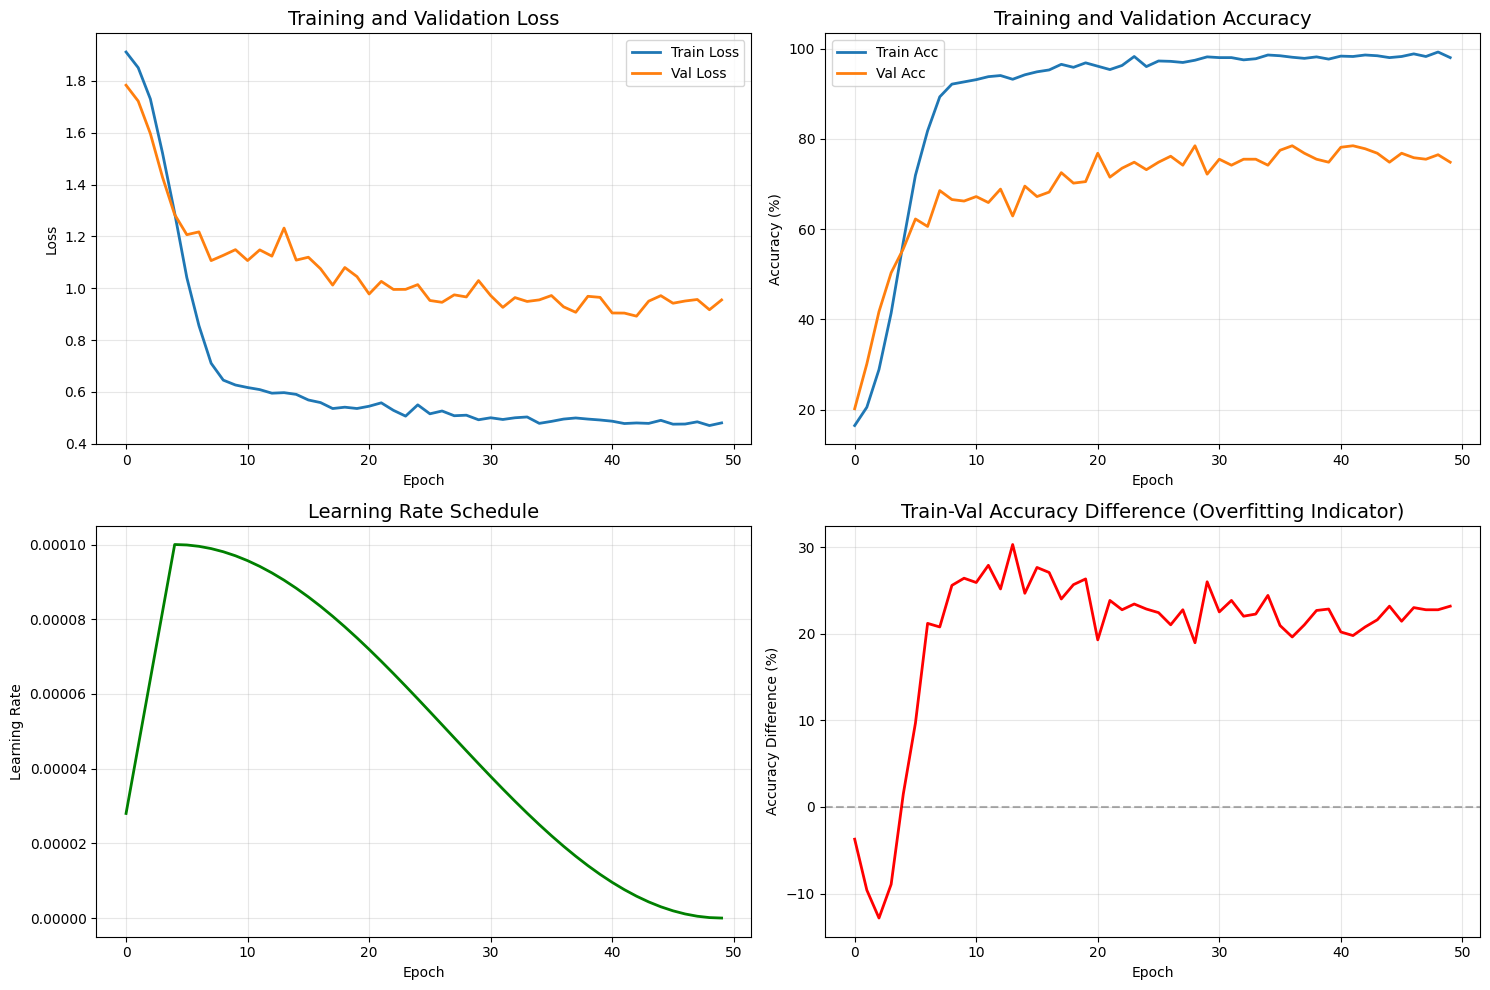


Évaluation sur l'ensemble de validation...

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

       anger       0.81      0.91      0.85        64
     disgust       0.81      0.62      0.71        48
        fear       0.74      0.67      0.71        52
   happiness       0.75      0.63      0.69        52
     neutral       0.60      0.83      0.70        35
     sadness       0.76      0.80      0.78        51

    accuracy                           0.75       302
   macro avg       0.75      0.75      0.74       302
weighted avg       0.76      0.75      0.75       302



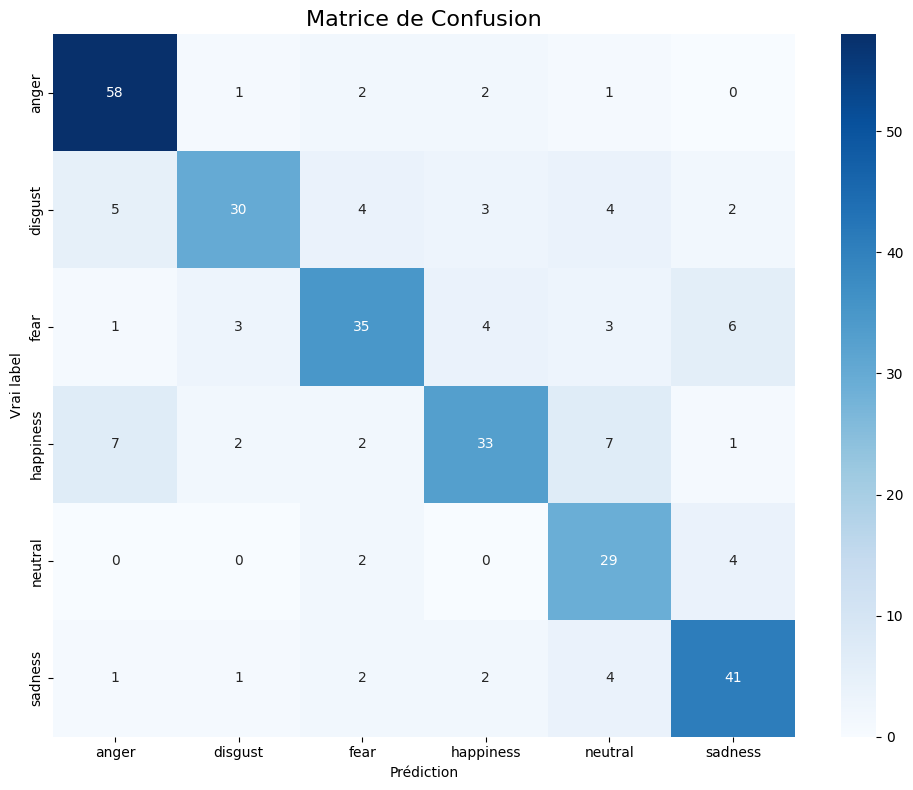


Accuracy par classe:
  anger: 90.62%
  disgust: 62.50%
  fear: 67.31%
  happiness: 63.46%
  neutral: 82.86%
  sadness: 80.39%

TEST SUR QUELQUES EXEMPLES

Exemple 1:
Fichier: Actor_21_03-01-04-01-02-02-21.wav
Vraie émotion: sadness

Prédiction pour Actor_21_03-01-04-01-02-02-21.wav:
Émotion prédite: sadness

Probabilités par émotion:
  anger: 2.36%
  disgust: 5.26%
  fear: 2.86%
  happiness: 2.69%
  neutral: 1.72%
  sadness: 85.10%

Exemple 2:
Fichier: Actor_21_03-01-05-02-01-01-21.wav
Vraie émotion: anger

Prédiction pour Actor_21_03-01-05-02-01-01-21.wav:
Émotion prédite: disgust

Probabilités par émotion:
  anger: 0.66%
  disgust: 94.80%
  fear: 0.91%
  happiness: 0.97%
  neutral: 1.02%
  sadness: 1.63%

Exemple 3:
Fichier: 14a02Wc.wav
Vraie émotion: anger

Prédiction pour 14a02Wc.wav:
Émotion prédite: disgust

Probabilités par émotion:
  anger: 1.16%
  disgust: 90.01%
  fear: 1.14%
  happiness: 2.62%
  neutral: 2.44%
  sadness: 2.63%

SAUVEGARDE FINALE
Modèle sauvegardé à: /conten

In [ ]:

def create_optimized_resnet_model(num_classes, dropout_rate=0.5):
    """
    Crée un modèle ResNet avec techniques anti-overfitting
    """
    # Charger ResNet50 pré-entraîné
    model = models.resnet50(pretrained=True)

    # Geler les premières couches (transfer learning prudent)
    # Ne geler que les premières couches, laisser les dernières entraînables
    layers_to_freeze = ['conv1', 'bn1', 'layer1', 'layer2']
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_freeze):
            param.requires_grad = False

    # Remplacer la dernière couche avec régularisation
    num_features = model.fc.in_features

    # Couche FC avec régularisation
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(dropout_rate * 0.7),
        nn.Linear(256, num_classes)
    )

    # Ajouter dropout supplémentaire après les blocs convolutionnels
    model.layer4.add_module('extra_dropout', nn.Dropout2d(0.1))

    return model

# ====================
# 11. FONCTIONS D'ENTRAÎNEMENT AVEC EARLY STOPPING
# ====================
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, val_acc, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model_state = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model_state = model.state_dict().copy()
            self.counter = 0

def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    """
    Une époque d'entraînement avec gradient clipping
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels, _) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping pour éviter les explosions de gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Affichage de progression
        if batch_idx % 10 == 0:
            print(f'  Batch {batch_idx}/{len(dataloader)} - Loss: {loss.item():.4f}')

    if scheduler:
        scheduler.step()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validation
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total

    return val_loss, val_acc, all_preds, all_labels

# ====================
#  CONFIGURATION D'ENTRAÎNEMENT OPTIMISÉE
# ====================
print("\n" + "="*50)
print("CONFIGURATION D'ENTRAÎNEMENT OPTIMISÉE")
print("="*50)

# Réinitialiser avec le dataset augmenté
print("\nCréation du dataset avec augmentation...")
augmented_dataset = AugmentedEmotionDataset(all_data, transform=transform, cache_dir=cache_dir, augment_prob=0.7)

# Split train/validation
from sklearn.model_selection import train_test_split

# Obtenir les indices
indices = list(range(len(augmented_dataset)))
labels = [augmented_dataset.data_df.iloc[i]['emotion'] for i in indices]

# Stratified split
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(augmented_dataset, train_idx)
val_dataset = torch.utils.data.Subset(augmented_dataset, val_idx)

print(f"Train samples (avec augmentation): {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# DataLoaders avec plus de workers pour le training
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Créer le modèle optimisé
print("\nCréation du modèle ResNet optimisé...")
model = create_optimized_resnet_model(num_classes, dropout_rate=0.6)
model = model.to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Paramètres totaux: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")

# Configuration d'entraînement optimisée
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing pour régularisation
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4  # L2 regularization
)

# Learning rate scheduler avec warmup
def cosine_annealing_with_warmup(optimizer, epochs, warmup_epochs=5):
    """Scheduler avec warmup et cosine annealing"""
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Warmup: linéaire de 0.1*lr à lr
            return 0.1 + 0.9 * (epoch / warmup_epochs)
        else:
            # Cosine annealing
            progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Nombre d'epochs optimisé (beaucoup moins que 800)
EPOCHS = 50  # Suffisant avec un bon scheduler
warmup_epochs = 5

scheduler = cosine_annealing_with_warmup(optimizer, EPOCHS, warmup_epochs)

# Early stopping
early_stopping = EarlyStopping(patience=15, min_delta=0.002, verbose=True)

# ====================
#  ENTRAÎNEMENT
# ====================
print("\n" + "="*50)
print("DÉBUT DE L'ENTRAÎNEMENT")
print("="*50)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rate': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Entraînement
    print("Phase d'entraînement...")
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, scheduler
    )

    # Validation
    print("Phase de validation...")
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device
    )

    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])

    # Affichage des résultats
    print(f"\nRésultats de l'epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Sauvegarder le meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, '/content/drive/MyDrive/best_emotion_model.pth')
        print(f"  ✓ Modèle sauvegardé (meilleure accuracy: {val_acc:.2f}%)")

    # Early stopping
    early_stopping(val_loss, val_acc, model)
    if early_stopping.early_stop:
        print(f"\n⚠️  Early stopping déclenché à l'epoch {epoch+1}")
        # Charger le meilleur modèle
        model.load_state_dict(early_stopping.best_model_state)
        break

    print(f"{'='*60}")

# ====================
#  VISUALISATION DES RÉSULTATS
# ====================
def plot_training_history(history):
    """
    Visualise l'historique d'entraînement
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate
    axes[1, 0].plot(history['learning_rate'], 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy diff (overfitting indicator)
    acc_diff = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
    axes[1, 1].plot(acc_diff, 'r-', linewidth=2)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_title('Train-Val Accuracy Difference (Overfitting Indicator)', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference (%)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\nVisualisation de l'historique d'entraînement...")
plot_training_history(history)

# ====================
# ÉVALUATION DÉTAILLÉE
# ====================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, device, emotion_mapping):
    """
    Évaluation détaillée du modèle
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_emotions = []

    with torch.no_grad():
        for inputs, labels, emotions in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_emotions.extend(emotions)

    # Convertir les indices en noms d'émotions
    idx_to_emotion = emotion_mapping[1]
    pred_emotions = [idx_to_emotion[p] for p in all_preds]
    true_emotions = [idx_to_emotion[l] for l in all_labels]

    # Rapport de classification
    print("\n" + "="*60)
    print("RAPPORT DE CLASSIFICATION")
    print("="*60)
    print(classification_report(true_emotions, pred_emotions, target_names=list(idx_to_emotion.values())))

    # Matrice de confusion
    emotion_names = list(idx_to_emotion.values())
    cm = confusion_matrix(true_emotions, pred_emotions, labels=emotion_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names,
                yticklabels=emotion_names)
    plt.title('Matrice de Confusion', fontsize=16)
    plt.ylabel('Vrai label')
    plt.xlabel('Prédiction')
    plt.tight_layout()
    plt.show()

    # Calcul de l'accuracy par classe
    class_acc = cm.diagonal() / cm.sum(axis=1)
    print("\nAccuracy par classe:")
    for emotion, acc in zip(emotion_names, class_acc):
        print(f"  {emotion}: {acc:.2%}")

    return pred_emotions, true_emotions

print("\nÉvaluation sur l'ensemble de validation...")
emotion_mapping = augmented_dataset.get_emotion_mapping()
preds, truths = evaluate_model(model, val_loader, device, emotion_mapping)

# ====================
# 16. TEST SUR QUELQUES EXEMPLES
# ====================
def test_single_example(model, audio_path, device, emotion_mapping):
    """
    Test sur un seul fichier audio
    """
    # Convertir en mel-spectrogramme
    mel_spec = audio_to_melspectrogram(audio_path, target_length=DURATION)

    if mel_spec is None:
        print("Erreur lors de la conversion")
        return

    # Préparer l'input
    mel_spec = np.stack([mel_spec, mel_spec, mel_spec], axis=0)  # 3 canaux
    mel_spec_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)  # Ajouter dimension batch

    # Appliquer les mêmes transformations
    mel_spec_tensor = transform(mel_spec_tensor)

    # Prédiction
    model.eval()
    with torch.no_grad():
        mel_spec_tensor = mel_spec_tensor.to(device)
        output = model(mel_spec_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        _, predicted = output.max(1)

    idx_to_emotion = emotion_mapping[1]
    predicted_emotion = idx_to_emotion[predicted.item()]

    # Afficher les probabilités
    print(f"\nPrédiction pour {os.path.basename(audio_path)}:")
    print(f"Émotion prédite: {predicted_emotion}")
    print("\nProbabilités par émotion:")
    for idx, prob in enumerate(probabilities[0].cpu().numpy()):
        emotion = idx_to_emotion[idx]
        print(f"  {emotion}: {prob:.2%}")

    return predicted_emotion

# Tester sur quelques fichiers
print("\n" + "="*60)
print("TEST SUR QUELQUES EXEMPLES")
print("="*60)

# Prendre quelques fichiers de test
test_files = all_data.sample(min(3, len(all_data))).reset_index(drop=True)

for idx, row in test_files.iterrows():
    print(f"\nExemple {idx+1}:")
    print(f"Fichier: {os.path.basename(row['file_path'])}")
    print(f"Vraie émotion: {row['emotion']}")
    test_single_example(model, row['file_path'], device, emotion_mapping)

# ====================
# 17. SAUVEGARDE FINALE
# ====================
print("\n" + "="*60)
print("SAUVEGARDE FINALE")
print("="*60)

# Sauvegarder le modèle final
final_save_path = '/content/drive/MyDrive/emotion_recognition_final.pth'
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'emotion_mapping': emotion_mapping,
    'best_val_acc': best_val_acc,
    'config': {
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mels': N_MELS,
        'batch_size': BATCH_SIZE,
        'learning_rate': 1e-4,
        'dropout_rate': 0.6
    }
}, final_save_path)

print(f"Modèle sauvegardé à: {final_save_path}")
print(f"Meilleure accuracy de validation: {best_val_acc:.2f}%")

# Sauvegarder l'historique
history_df = pd.DataFrame(history)
history_df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)
print("Historique d'entraînement sauvegardé")

print("\n" + "="*60)
print("ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
print("="*60)

=> Accuracy slightly improved from 74.43% (training without data augmentaiton) to 78.48 (Training with traditional data augmentation with mel-spectograms)

**Save Tarined Resnet50 model**

In [ ]:

print("\n" + "="*60)
print("SAUVEGARDE COMPLÈTE POUR DIFFUSION MODEL")
print("="*60)



final_save_path = '/content/drive/MyDrive/emotion_recognition_complete.pth'

# Charger le meilleur modèle si early stopping
if os.path.exists('/content/drive/MyDrive/best_emotion_model.pth'):
    checkpoint = torch.load('/content/drive/MyDrive/best_emotion_model.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Meilleur modèle rechargé")

# Sauvegarder TOUT
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'emotion_mapping': emotion_mapping,
    'best_val_acc': best_val_acc,
    'config': {
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mels': N_MELS,
        'batch_size': BATCH_SIZE,
        'learning_rate': 1e-4,
        'dropout_rate': 0.6,
        'num_classes': num_classes
    }
}, final_save_path)

print(f"✓ Modèle ResNet sauvegardé: {final_save_path}")

# ====================
#  SAUVEGARDER LES MÉTADONNÉES DU DATASET
# ====================

import pickle

dataset_metadata = {
    'data_df': all_data,  # DataFrame avec les chemins des fichiers
    'emotion_to_idx': augmented_dataset.emotion_to_idx,
    'idx_to_emotion': augmented_dataset.idx_to_emotion,
    'emotions': augmented_dataset.emotions,
    'cache_dir': cache_dir,
    'total_samples': len(all_data),
    'train_idx': train_idx,
    'val_idx': val_idx
}

with open('/content/drive/MyDrive/dataset_metadata.pkl', 'wb') as f:
    pickle.dump(dataset_metadata, f)

print(f"✓ Métadonnées dataset sauvegardées")

# ====================
# 3. EXTRAIRE ET SAUVEGARDER LES EMBEDDINGS ÉMOTIONNELS
# ====================

print("\n" + "="*60)
print("EXTRACTION DES EMBEDDINGS ÉMOTIONNELS")
print("="*60)

def extract_embeddings(model, dataloader, device):
    """Extrait les embeddings de chaque échantillon"""
    model.eval()

    all_embeddings = []
    all_labels = []

    # Vérifier si le modèle a l'attribut 'resnet' (EmotionResNet) ou non (ResNet direct)
    has_wrapper = hasattr(model, 'resnet')

    with torch.no_grad():
        for batch_idx, (inputs, labels, _) in enumerate(tqdm(dataloader, desc="Extraction")):
            inputs = inputs.to(device)

            # Extraire features avant la couche FC
            if has_wrapper:
                # Si c'est EmotionResNet (avec wrapper)
                x = model.resnet.conv1(inputs)
                x = model.resnet.bn1(x)
                x = model.resnet.relu(x)
                x = model.resnet.maxpool(x)

                x = model.resnet.layer1(x)
                x = model.resnet.layer2(x)
                x = model.resnet.layer3(x)
                x = model.resnet.layer4(x)

                x = model.resnet.avgpool(x)
            else:
                # Si c'est ResNet direct de torchvision
                x = model.conv1(inputs)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)

                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)

                x = model.avgpool(x)

            embedding = torch.flatten(x, 1)  # (batch, 2048)

            all_embeddings.append(embedding.cpu())
            all_labels.extend(labels.numpy())

    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings, all_labels

# Créer un DataLoader pour TOUT le dataset (train + val)
full_dataset_loader = DataLoader(
    augmented_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

embeddings, labels = extract_embeddings(model, full_dataset_loader, device)

print(f"✓ Embeddings extraits: {embeddings.shape}")

# Sauvegarder les embeddings
torch.save({
    'embeddings': embeddings,
    'labels': labels,
    'emotion_to_idx': augmented_dataset.emotion_to_idx
}, '/content/drive/MyDrive/emotion_embeddings.pth', _use_new_zipfile_serialization=True)

print(f"✓ Embeddings sauvegardés")

# ====================
# 4. CALCULER LES EMBEDDINGS MOYENS PAR ÉMOTION
# ====================

emotion_centroids = {}
for emotion_name, emotion_idx in augmented_dataset.emotion_to_idx.items():
    mask = torch.tensor([l == emotion_idx for l in labels])
    emotion_embs = embeddings[mask]
    centroid = emotion_embs.mean(dim=0)
    emotion_centroids[emotion_name] = centroid

print(f"\n✓ Centroïdes calculés pour {len(emotion_centroids)} émotions")

# Sauvegarder les centroïdes
torch.save(emotion_centroids, '/content/drive/MyDrive/emotion_centroids.pth')

# ====================
# 5. CRÉER UN FICHIER DE CONFIGURATION GLOBAL
# ====================

global_config = {
    # Chemins des fichiers sauvegardés
    'paths': {
        'resnet_model': '/content/drive/MyDrive/emotion_recognition_complete.pth',
        'dataset_metadata': '/content/drive/MyDrive/dataset_metadata.pkl',
        'embeddings': '/content/drive/MyDrive/emotion_embeddings.pth',
        'centroids': '/content/drive/MyDrive/emotion_centroids.pth',
        'cache_dir': cache_dir
    },

    # Configuration audio
    'audio_config': {
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mels': N_MELS,
        'n_fft': 1024,
        'hop_length': 256
    },

    # Configuration modèle
    'model_config': {
        'num_classes': num_classes,
        'dropout_rate': 0.6,
        'architecture': 'resnet50'
    },

    # Émotions
    'emotions': {
        'emotion_to_idx': augmented_dataset.emotion_to_idx,
        'idx_to_emotion': augmented_dataset.idx_to_emotion,
        'emotions_list': augmented_dataset.emotions
    },

    # Statistiques
    'stats': {
        'total_samples': len(all_data),
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'best_val_acc': best_val_acc
    }
}

with open('/content/drive/MyDrive/global_config.pkl', 'wb') as f:
    pickle.dump(global_config, f)

print(f"✓ Configuration globale sauvegardée")

# ====================
# 6. SAUVEGARDER L'HISTORIQUE
# ====================

history_df = pd.DataFrame(history)
history_df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)
print("✓ Historique sauvegardé")


# ====================
# 8. RÉSUMÉ DES FICHIERS SAUVEGARDÉS
# ====================

print("\n" + "="*70)
print("FICHIERS SAUVEGARDÉS")
print("="*70)

saved_files = {
    'emotion_recognition_complete.pth': 'Modèle ResNet complet',
    'dataset_metadata.pkl': 'Métadonnées du dataset',
    'emotion_embeddings.pth': 'Embeddings de tous les échantillons',
    'emotion_centroids.pth': 'Centroïdes par émotion',
    'global_config.pkl': 'Configuration complète',
    'training_history.csv': 'Historique d\'entraînement',
    'load_for_diffusion.py': 'Script de chargement rapide'
}

for filename, description in saved_files.items():
    filepath = f'/content/drive/MyDrive/{filename}'
    exists = "✓" if os.path.exists(filepath) else "✗"
    size = os.path.getsize(filepath) / (1024*1024) if os.path.exists(filepath) else 0
    print(f"{exists} {filename:<35} ({size:.2f} MB) - {description}")

print("\n" + "="*70)
print("✓ SAUVEGARDE COMPLÈTE TERMINÉE")
print("="*70)





SAUVEGARDE COMPLÈTE POUR DIFFUSION MODEL
✓ Meilleur modèle rechargé
✓ Modèle ResNet sauvegardé: /content/drive/MyDrive/emotion_recognition_complete.pth
✓ Métadonnées dataset sauvegardées

EXTRACTION DES EMBEDDINGS ÉMOTIONNELS


Extraction:  52%|█████▏    | 25/48 [00:06<00:04,  5.16it/s]

[15:04:55] Session maintenue active...


<IPython.core.display.Javascript object>

Extraction: 100%|██████████| 48/48 [00:11<00:00,  4.11it/s]


✓ Embeddings extraits: torch.Size([1510, 2048])
✓ Embeddings sauvegardés

✓ Centroïdes calculés pour 6 émotions
✓ Configuration globale sauvegardée
✓ Historique sauvegardé
✓ Script de chargement créé: load_for_diffusion.py

FICHIERS SAUVEGARDÉS
✓ emotion_recognition_complete.pth    (233.36 MB) - Modèle ResNet complet
✓ dataset_metadata.pkl                (0.19 MB) - Métadonnées du dataset
✓ emotion_embeddings.pth              (11.87 MB) - Embeddings de tous les échantillons
✓ emotion_centroids.pth               (0.05 MB) - Centroïdes par émotion
✓ global_config.pkl                   (0.00 MB) - Configuration complète
✓ training_history.csv                (0.00 MB) - Historique d'entraînement
✓ load_for_diffusion.py               (0.01 MB) - Script de chargement rapide

✓ SAUVEGARDE COMPLÈTE TERMINÉE

🎯 PROCHAINES ÉTAPES:
1. Pour utiliser le diffusion model, copiez le contenu de:
   /content/drive/MyDrive/load_for_diffusion.py
2. Collez-le au début d'un nouveau notebook
3. Toutes les va

**Load  Trained Resnet50 Model for diffusion**

In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("🔄 CHARGEMENT RAPIDE POUR DIFFUSION MODEL")
print("="*70)

# ====================
# 1. CHARGER LA CONFIGURATION
# ====================

with open('/content/drive/MyDrive/global_config.pkl', 'rb') as f:
    config = pickle.load(f)

# Variables globales
SAMPLE_RATE = config['audio_config']['sample_rate']
DURATION = config['audio_config']['duration']
N_MELS = config['audio_config']['n_mels']
cache_dir = config['paths']['cache_dir']
num_classes = config['model_config']['num_classes']

emotion_to_idx = config['emotions']['emotion_to_idx']
idx_to_emotion = config['emotions']['idx_to_emotion']
emotions = config['emotions']['emotions_list']

print(f"✓ Configuration chargée")
print(f"  Sample rate: {SAMPLE_RATE} Hz")
print(f"  Duration: {DURATION} s")
print(f"  N_mels: {N_MELS}")
print(f"  Classes: {num_classes}")
print(f"  Émotions: {emotions}")

# ====================
# 2. CHARGER LE DATASET
# ====================

with open('/content/drive/MyDrive/dataset_metadata.pkl', 'rb') as f:
    dataset_meta = pickle.load(f)

all_data = dataset_meta['data_df']
train_idx = dataset_meta['train_idx']
val_idx = dataset_meta['val_idx']

print(f"\n✓ Dataset chargé: {len(all_data)} échantillons")
print(f"  Train: {len(train_idx)}")
print(f"  Val: {len(val_idx)}")

# ====================
# 3. DÉFINIR LES CLASSES NÉCESSAIRES
# ====================

class EmotionResNet(nn.Module):
    """Même architecture que l'entraînement"""
    def __init__(self, num_classes, dropout_rate=0.6):
        super().__init__()
        self.resnet = models.resnet50(pretrained=False)

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

    def get_embedding(self, x):
        """Extraire embeddings pour diffusion"""
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        return torch.flatten(x, 1)

def audio_to_melspectrogram(audio_path, target_length=DURATION):
    """Conversion audio → mel-spectrogramme"""
    try:
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=target_length)

        target_samples = int(target_length * SAMPLE_RATE)
        if len(audio) < target_samples:
            audio = np.pad(audio, (0, target_samples - len(audio)))
        else:
            audio = audio[:target_samples]

        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=1024,
            hop_length=256
        )
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec

    except Exception as e:
        print(f"Erreur {audio_path}: {e}")
        return None

class DiffusionDataset(Dataset):
    """Dataset pour entraîner le diffusion model"""
    def __init__(self, data_df, cache_dir, emotion_to_idx):
        self.data_df = data_df
        self.cache_dir = cache_dir
        self.emotion_to_idx = emotion_to_idx
        self.idx_to_emotion = {v: k for k, v in emotion_to_idx.items()}
        self.emotions = list(emotion_to_idx.keys())

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        audio_path = row['file_path']
        emotion = row['emotion']

        # Cache
        cache_name = f"{os.path.basename(audio_path).split('.')[0]}.npy"
        cache_path = os.path.join(self.cache_dir, cache_name)

        if os.path.exists(cache_path):
            mel_spec = np.load(cache_path)
        else:
            mel_spec = audio_to_melspectrogram(audio_path)
            if mel_spec is None:
                mel_spec = np.zeros((N_MELS, int(DURATION * SAMPLE_RATE / 256) + 1))
            np.save(cache_path, mel_spec)

        # Normalisation
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)
        mel_spec_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)  # (1, H, W)

        label = self.emotion_to_idx[emotion]
        return mel_spec_tensor, label

    def get_emotion_mapping(self):
        return self.emotion_to_idx, self.idx_to_emotion

# ====================
# 4. CHARGER LE MODÈLE RESNET (avec détection automatique)
# ====================

# Charger le checkpoint d'abord pour inspecter
checkpoint = torch.load('/content/drive/MyDrive/emotion_recognition_complete.pth', map_location=device, weights_only=False)

# Détecter le type de modèle sauvegardé
state_dict = checkpoint['model_state_dict']
first_key = list(state_dict.keys())[0]
is_wrapped = first_key.startswith('resnet.')

print(f"\n🔍 Détection du modèle sauvegardé...")
print(f"  Type: {'EmotionResNet (avec wrapper)' if is_wrapped else 'ResNet direct (sans wrapper)'}")

if is_wrapped:
    # Modèle avec wrapper EmotionResNet
    resnet_model = EmotionResNet(num_classes=num_classes).to(device)
    resnet_model.load_state_dict(state_dict)
else:
    # Modèle ResNet direct - on doit le wrapper
    print("  → Création du wrapper pour compatibilité...")

    # Créer le modèle ResNet de base
    base_resnet = models.resnet50(pretrained=False)

    # Modifier la dernière couche pour correspondre
    num_features = base_resnet.fc.in_features
    base_resnet.fc = nn.Sequential(
        nn.Dropout(0.6),
        nn.Linear(num_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.42),
        nn.Linear(256, num_classes)
    )

    # Charger les poids
    base_resnet.load_state_dict(state_dict)
    base_resnet = base_resnet.to(device)

    # Wrapper dans EmotionResNet pour compatibilité
    resnet_model = EmotionResNet(num_classes=num_classes).to(device)
    resnet_model.resnet = base_resnet

resnet_model.eval()

print(f"✓ Modèle ResNet chargé et prêt")
print(f"  Best Val Acc: {checkpoint.get('best_val_acc', 'N/A'):.2f}%")

# ====================
# 5. CHARGER LES EMBEDDINGS PRÉ-CALCULÉS
# ====================

embeddings_data = torch.load('/content/drive/MyDrive/emotion_embeddings.pth', map_location='cpu', weights_only=False)
precomputed_embeddings = embeddings_data['embeddings']
embedding_labels = embeddings_data['labels']

print(f"\n✓ Embeddings pré-calculés chargés")
print(f"  Shape: {precomputed_embeddings.shape}")

# ====================
# 6. CHARGER LES CENTROÏDES ÉMOTIONNELS
# ====================

emotion_centroids = torch.load('/content/drive/MyDrive/emotion_centroids.pth', map_location='cpu', weights_only=False)

print(f"\n✓ Centroïdes émotionnels chargés")
for emotion, centroid in emotion_centroids.items():
    print(f"  {emotion}: {centroid.shape}")

# ====================
# 7. CRÉER LE DATASET ET DATALOADER
# ====================

diffusion_dataset = DiffusionDataset(all_data, cache_dir, emotion_to_idx)

diffusion_loader = DataLoader(
    diffusion_dataset,
    batch_size=8,  # Optimisé pour T4
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"\n✓ DiffusionDataset créé")
print(f"  Total: {len(diffusion_dataset)} échantillons")
print(f"  Batches: {len(diffusion_loader)}")

# ====================
# 8. RÉSUMÉ
# ====================

print("\n" + "="*70)
print("✅ CHARGEMENT TERMINÉ - PRÊT POUR DIFFUSION MODEL")
print("="*70)

print("\n📦 Variables disponibles:")
print(f"  • resnet_model        : Modèle ResNet entraîné ({sum(p.numel() for p in resnet_model.parameters()):,} params)")
print(f"  • diffusion_dataset   : Dataset ({len(diffusion_dataset)} samples)")
print(f"  • diffusion_loader    : DataLoader (batch_size=8)")
print(f"  • precomputed_embeddings : Embeddings pré-calculés {precomputed_embeddings.shape}")
print(f"  • emotion_centroids   : Centroïdes ({len(emotion_centroids)} émotions)")
print(f"  • emotion_to_idx      : Mapping émotions → indices")
print(f"  • idx_to_emotion      : Mapping indices → émotions")
print(f"  • all_data            : DataFrame ({len(all_data)} fichiers)")
print(f"  • SAMPLE_RATE         : {SAMPLE_RATE}")
print(f"  • DURATION            : {DURATION}")
print(f"  • N_MELS              : {N_MELS}")

print("\n🎯 Prochaine étape:")
print("   Exécutez le code du diffusion model pour générer des données synthétiques")

# ====================
# 9. FONCTION UTILITAIRE POUR VISUALISER
# ====================

def show_sample(idx=0):
    """Visualise un échantillon du dataset"""
    import matplotlib.pyplot as plt

    mel_spec, label = diffusion_dataset[idx]
    emotion = idx_to_emotion[label]

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Amplitude (dB)')
    plt.title(f'Mel-spectrogramme - Émotion: {emotion}')
    plt.xlabel('Temps')
    plt.ylabel('Mel bins')
    plt.tight_layout()
    plt.show()

    print(f"Émotion: {emotion} (idx={label})")
    print(f"Shape: {mel_spec.shape}")

print("\n💡 Utilisez show_sample(idx) pour visualiser un échantillon")

# Libérer la mémoire
import gc
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("\n✓ Mémoire nettoyée")

🔄 CHARGEMENT RAPIDE POUR DIFFUSION MODEL
✓ Configuration chargée
  Sample rate: 22050 Hz
  Duration: 3 s
  N_mels: 128
  Classes: 6
  Émotions: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']

✓ Dataset chargé: 1510 échantillons
  Train: 1208
  Val: 302

🔍 Détection du modèle sauvegardé...
  Type: ResNet direct (sans wrapper)
  → Création du wrapper pour compatibilité...
✓ Modèle ResNet chargé et prêt
  Best Val Acc: 78.48%

✓ Embeddings pré-calculés chargés
  Shape: torch.Size([1510, 2048])

✓ Centroïdes émotionnels chargés
  anger: torch.Size([2048])
  disgust: torch.Size([2048])
  fear: torch.Size([2048])
  happiness: torch.Size([2048])
  neutral: torch.Size([2048])
  sadness: torch.Size([2048])

✓ DiffusionDataset créé
  Total: 1510 échantillons
  Batches: 189

✅ CHARGEMENT TERMINÉ - PRÊT POUR DIFFUSION MODEL

📦 Variables disponibles:
  • resnet_model        : Modèle ResNet entraîné (24,034,630 params)
  • diffusion_dataset   : Dataset (1510 samples)
  • diffusion_l

# 14. Diffusion Model for Synthetic Data Generation

In [ ]:


print("\n" + "="*70)
print("DIFFUSION MODEL AVEC EMBEDDINGS RESNET - OPTIMISÉ T4 GPU")
print("="*70)

# Vérifier GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ Mémoire: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.backends.cudnn.benchmark = True
else:
    print("⚠️ CPU mode - sera très lent!")

**Diffusion Model Components**

**Sinusoidal Time Embedding And Residual Block**

In [ ]:
class SinusoidalEmbedding(nn.Module):
    """Embeddings temporels sinusoïdaux"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb


class ResBlock(nn.Module):
    """
    Bloc résiduel léger avec embeddings
    Version optimisée pour T4
    """
    def __init__(self, channels, time_dim, emotion_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, channels)

        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, channels)

        # Projections pour embeddings
        self.time_proj = nn.Linear(time_dim, channels)
        self.emotion_proj = nn.Linear(emotion_dim, channels)

    def forward(self, x, t_emb, e_emb):
        h = self.conv1(x)
        h = self.norm1(h)

        # Ajouter embeddings
        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = h + self.emotion_proj(e_emb)[:, :, None, None]

        h = F.silu(h)
        h = self.conv2(h)
        h = self.norm2(h)

        return F.silu(h + x)

**Compact Diffusion U-Net**

In [ ]:



class CompactDiffusionUNet(nn.Module):
    """
    U-Net compact pour diffusion
    Optimisé pour T4 GPU avec mel-spectrogrammes
    Utilise embeddings ResNet comme dans le paper
    FIXÉ: Problèmes de dimensions avec padding
    """
    def __init__(self,
                 emotion_embedding_dim=2048,  # Dimension embedding ResNet
                 base_channels=64,  # Réduit pour T4
                 time_dim=128):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 2),
            nn.SiLU(),
            nn.Linear(time_dim * 2, time_dim)
        )

        # Emotion embedding projection (2048 -> 128)
        self.emotion_proj = nn.Sequential(
            nn.Linear(emotion_embedding_dim, 512),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(512, time_dim)
        )

        # Entrée: 1 canal (mel-spectrogramme)
        self.init_conv = nn.Conv2d(1, base_channels, 3, padding=1)

        # Encoder (downsampling)
        self.down1 = nn.ModuleList([
            ResBlock(base_channels, time_dim, time_dim),
            ResBlock(base_channels, time_dim, time_dim)
        ])
        self.down1_pool = nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1)

        self.down2 = nn.ModuleList([
            ResBlock(base_channels*2, time_dim, time_dim),
            ResBlock(base_channels*2, time_dim, time_dim)
        ])
        self.down2_pool = nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1)

        # Bottleneck
        self.mid = nn.ModuleList([
            ResBlock(base_channels*4, time_dim, time_dim),
            ResBlock(base_channels*4, time_dim, time_dim)
        ])

        # Decoder (upsampling) - FIXÉ avec output_padding
        self.up1_conv = nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, stride=2, padding=1, output_padding=0)
        self.up1 = nn.ModuleList([
            ResBlock(base_channels*4, time_dim, time_dim),  # *4 car concat
            ResBlock(base_channels*4, time_dim, time_dim)
        ])
        self.up1_reduce = nn.Conv2d(base_channels*4, base_channels*2, 1)

        self.up2_conv = nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1, output_padding=0)
        self.up2 = nn.ModuleList([
            ResBlock(base_channels*2, time_dim, time_dim),  # *2 car concat
            ResBlock(base_channels*2, time_dim, time_dim)
        ])
        self.up2_reduce = nn.Conv2d(base_channels*2, base_channels, 1)

        # Output
        self.out = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, 1, 3, padding=1)
        )

    def forward(self, x, t, emotion_emb):
        """
        Args:
            x: (B, 1, H, W) mel-spectrogramme bruité
            t: (B,) timestep
            emotion_emb: (B, 2048) embedding ResNet
        """
        # Embeddings
        t_emb = self.time_mlp(t)
        e_emb = self.emotion_proj(emotion_emb)

        # Init
        x = self.init_conv(x)  # (B, 64, H, W)

        # Encoder
        h1 = x
        for block in self.down1:
            h1 = block(h1, t_emb, e_emb)

        h2 = self.down1_pool(h1)  # (B, 128, H/2, W/2)
        for block in self.down2:
            h2 = block(h2, t_emb, e_emb)

        h3 = self.down2_pool(h2)  # (B, 256, H/4, W/4)

        # Bottleneck
        h = h3
        for block in self.mid:
            h = block(h, t_emb, e_emb)

        # Decoder avec skip connections + INTERPOLATION pour corriger dimensions
        h = self.up1_conv(h)  # (B, 128, H/2, W/2)

        # Corriger dimensions si nécessaire
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='bilinear', align_corners=False)

        h = torch.cat([h, h2], dim=1)  # (B, 256, H/2, W/2)
        for block in self.up1:
            h = block(h, t_emb, e_emb)
        h = self.up1_reduce(h)  # (B, 128, H/2, W/2)

        h = self.up2_conv(h)  # (B, 64, H, W)

        # Corriger dimensions si nécessaire
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='bilinear', align_corners=False)

        h = torch.cat([h, h1], dim=1)  # (B, 128, H, W)
        for block in self.up2:
            h = block(h, t_emb, e_emb)
        h = self.up2_reduce(h)  # (B, 64, H, W)

        return self.out(h)  # (B, 1, H, W)

# 15. Diffusion Process

In [ ]:

class DiffusionProcess:
    """Gère forward et reverse diffusion"""
    def __init__(self, timesteps=200, device='cuda'):
        self.timesteps = timesteps
        self.device = device

        # Cosine schedule (meilleur que linear selon le paper)
        self.betas = self._cosine_beta_schedule(timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        """Cosine schedule du paper DDPM"""
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def q_sample(self, x_start, t, noise=None):
        """Forward: ajouter du bruit"""
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alpha = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]

        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise

    @torch.no_grad()
    def p_sample(self, model, x, t, emotion_emb):
        """Reverse: retirer du bruit (1 step)"""
        beta = self.betas[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        sqrt_recip_alpha = torch.sqrt(1.0 / self.alphas[t])[:, None, None, None]

        # Prédire le bruit
        pred_noise = model(x, t, emotion_emb)

        # Calculer x_{t-1}
        model_mean = sqrt_recip_alpha * (x - beta * pred_noise / sqrt_one_minus_alpha)

        if t[0] == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            variance = self.posterior_variance[t][:, None, None, None]
            return model_mean + torch.sqrt(variance) * noise

    @torch.no_grad()
    def sample(self, model, shape, emotion_emb):
        """Génère un mel-spectrogramme depuis bruit"""
        b = shape[0]
        x = torch.randn(shape, device=self.device)

        for i in reversed(range(self.timesteps)):
            t = torch.full((b,), i, device=self.device, dtype=torch.long)
            x = self.p_sample(model, x, t, emotion_emb)

        return x

# 16. Extract Emotion Embeddings from ResNet

In [ ]:



class EmotionEmbeddingEncoder(nn.Module):
    """
    Extrait les embeddings émotionnels du ResNet entraîné
    Inspiré du paper: Section 4.2 - Speech Emotion Recognition
    """
    def __init__(self, resnet_model):
        super().__init__()
        self.resnet = resnet_model

        # Désactiver les gradients pour économiser mémoire
        for param in self.resnet.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def forward(self, mel_spec):
        """
        Extrait embedding de 2048 dimensions avant la couche FC
        """
        # S'assurer que c'est 3 canaux
        if mel_spec.shape[1] == 1:
            mel_spec = mel_spec.repeat(1, 3, 1, 1)

        # Forward jusqu'à avgpool
        if hasattr(self.resnet, 'resnet'):
            # Wrapper EmotionResNet
            x = self.resnet.resnet.conv1(mel_spec)
            x = self.resnet.resnet.bn1(x)
            x = self.resnet.resnet.relu(x)
            x = self.resnet.resnet.maxpool(x)
            x = self.resnet.resnet.layer1(x)
            x = self.resnet.resnet.layer2(x)
            x = self.resnet.resnet.layer3(x)
            x = self.resnet.resnet.layer4(x)
            x = self.resnet.resnet.avgpool(x)
        else:
            # ResNet direct
            x = self.resnet.conv1(mel_spec)
            x = self.resnet.bn1(x)
            x = self.resnet.relu(x)
            x = self.resnet.maxpool(x)
            x = self.resnet.layer1(x)
            x = self.resnet.layer2(x)
            x = self.resnet.layer3(x)
            x = self.resnet.layer4(x)
            x = self.resnet.avgpool(x)

        embedding = torch.flatten(x, 1)  # (B, 2048)
        return embedding

# 17. Train Diffusion Model

In [ ]:



def train_diffusion_with_embeddings(
    diffusion_model,
    resnet_model,
    dataloader,
    diffusion_process,
    epochs=30,
    lr=1e-4,
    save_path='/content/drive/MyDrive/diffusion_model.pth'
):
    """
    Entraîne le diffusion model avec embeddings ResNet
    Optimisé pour T4 GPU
    """

    print("\n" + "="*70)
    print("ENTRAÎNEMENT DU DIFFUSION MODEL")
    print("="*70)

    # Créer l'encodeur d'embeddings
    embedding_encoder = EmotionEmbeddingEncoder(resnet_model).to(device)
    embedding_encoder.eval()

    optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    diffusion_model.train()
    best_loss = float('inf')

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for mel_specs, labels in pbar:
            # Prendre 1 canal seulement
            if mel_specs.shape[1] == 3:
                mel_specs = mel_specs[:, 0:1, :, :]  # (B, 1, H, W)

            mel_specs = mel_specs.to(device)
            labels = labels.to(device)

            # Extraire embeddings émotionnels
            with torch.no_grad():
                if mel_specs.shape[1] == 1:
                    mel_3ch = mel_specs.repeat(1, 3, 1, 1)
                else:
                    mel_3ch = mel_specs
                emotion_emb = embedding_encoder(mel_3ch)

            # Sample timestep aléatoire
            batch_size = mel_specs.shape[0]
            t = torch.randint(0, diffusion_process.timesteps, (batch_size,), device=device)

            # Forward diffusion
            noise = torch.randn_like(mel_specs)
            x_noisy = diffusion_process.q_sample(mel_specs, t, noise)

            # Prédire le bruit
            pred_noise = diffusion_model(x_noisy, t, emotion_emb)

            # Loss
            loss = F.mse_loss(pred_noise, noise)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            # Libérer mémoire
            if num_batches % 10 == 0:
                del loss, pred_noise, x_noisy, noise, emotion_emb
                torch.cuda.empty_cache()

        scheduler.step()
        avg_loss = epoch_loss / num_batches

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")

        # Sauvegarder meilleur modèle
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': diffusion_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, save_path)
            print(f"✓ Meilleur modèle sauvegardé (loss: {avg_loss:.4f})")

        gc.collect()
        torch.cuda.empty_cache()

    print(f"\n✅ Entraînement terminé - Meilleure loss: {best_loss:.4f}")
    return diffusion_model



# 18. Generate Synthetic Data

In [ ]:


@torch.no_grad()
def generate_synthetic_data(
    diffusion_model,
    resnet_model,
    diffusion_process,
    emotion_centroids,
    num_samples_per_emotion=200,
    batch_size=4
):
    """
    Génère des données synthétiques en utilisant les centroïdes émotionnels

    Args:
        diffusion_model: Modèle de diffusion entraîné
        resnet_model: Modèle ResNet (pour référence)
        diffusion_process: Processus de diffusion
        emotion_centroids: Dict {emotion_name: centroid_tensor}
        num_samples_per_emotion: Nombre à générer par émotion
        batch_size: Batch size pour génération
    """

    print("\n" + "="*70)
    print("GÉNÉRATION DE DONNÉES SYNTHÉTIQUES")
    print("="*70)

    diffusion_model.eval()
    synthetic_data = []

    # Déterminer la forme des mel-spectrogrammes
    mel_shape = (1, 80, 862)  # (C, H, W) typique

    emotion_map = {
        'anger': 0, 'sadness': 1, 'fear': 2,
        'happiness': 3, 'neutral': 4, 'disgust': 5
    }

    for emotion_name, emotion_idx in emotion_map.items():
        if emotion_name not in emotion_centroids:
            print(f"⚠️ Centroïde manquant pour {emotion_name}, skip...")
            continue

        print(f"\n🎭 Génération pour {emotion_name.upper()}")
        centroid = emotion_centroids[emotion_name].to(device)

        # Générer par batches
        num_batches = (num_samples_per_emotion + batch_size - 1) // batch_size

        for batch_idx in tqdm(range(num_batches), desc=f"  {emotion_name}"):
            current_bs = min(batch_size, num_samples_per_emotion - batch_idx * batch_size)

            # Répéter le centroïde
            emotion_emb_batch = centroid.unsqueeze(0).repeat(current_bs, 1)

            # Ajouter variation au centroïde (important!)
            noise_scale = 0.1
            emotion_emb_batch = emotion_emb_batch + torch.randn_like(emotion_emb_batch) * noise_scale

            # Générer
            shape = (current_bs, *mel_shape)
            generated = diffusion_process.sample(diffusion_model, shape, emotion_emb_batch)

            # Convertir en 3 canaux pour compatibilité ResNet
            for i in range(current_bs):
                mel_1ch = generated[i].cpu()  # (1, H, W)
                mel_3ch = mel_1ch.repeat(3, 1, 1)  # (3, H, W)
                synthetic_data.append((mel_3ch, emotion_idx, emotion_name))

            # Libérer mémoire
            if (batch_idx + 1) % 5 == 0:
                del generated, emotion_emb_batch
                torch.cuda.empty_cache()

    print(f"\n✅ Génération terminée: {len(synthetic_data)} échantillons")

    # Afficher distribution
    print("\n📊 Distribution:")
    for name in emotion_map.keys():
        count = sum(1 for _, _, e in synthetic_data if e == name)
        print(f"  {name}: {count}")

    return synthetic_data

In [ ]:


def run_complete_pipeline(
    resnet_model,
    diffusion_dataset,
    diffusion_loader,
    emotion_centroids,
    diffusion_epochs=30,
    num_synthetic_per_emotion=200
):
    """
    Pipeline complet d'augmentation avec diffusion
    """

    print("\n" + "="*80)
    print("PIPELINE COMPLET D'AUGMENTATION PAR DIFFUSION")
    print("="*80)

    # 1. Créer le modèle de diffusion
    print("\n📦 Étape 1: Création du modèle de diffusion")
    diffusion_model = CompactDiffusionUNet(
        emotion_embedding_dim=2048,
        base_channels=64,
        time_dim=128
    ).to(device)

    total_params = sum(p.numel() for p in diffusion_model.parameters())
    print(f"   Paramètres: {total_params:,}")

    # 2. Créer le processus de diffusion
    print("\n⚙️ Étape 2: Initialisation du processus de diffusion")
    diffusion_process = DiffusionProcess(timesteps=200, device=device)
    print(f"   Timesteps: {diffusion_process.timesteps}")

    # 3. Entraîner
    print("\n🔥 Étape 3: Entraînement du modèle de diffusion")
    diffusion_model = train_diffusion_with_embeddings(
        diffusion_model,
        resnet_model,
        diffusion_loader,
        diffusion_process,
        epochs=diffusion_epochs,
        lr=1e-4
    )

    # 4. Générer données synthétiques
    print("\n🎨 Étape 4: Génération de données synthétiques")
    synthetic_data = generate_synthetic_data(
        diffusion_model,
        resnet_model,
        diffusion_process,
        emotion_centroids,
        num_samples_per_emotion=num_synthetic_per_emotion,
        batch_size=4
    )

    # 5. Sauvegarder (COMPLET ET SÉCURISÉ)
    print("\n💾 Étape 5: Sauvegarde complète")

    # Sauvegarder les données synthétiques
    synthetic_save_path = '/content/drive/MyDrive/synthetic_emotion_data_diffusion.pth'
    torch.save({
        'synthetic_data': synthetic_data,
        'num_samples': len(synthetic_data),
        'num_per_emotion': num_synthetic_per_emotion,
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S'),
        'emotion_distribution': {
            emotion: sum(1 for _, _, e in synthetic_data if e == emotion)
            for emotion in ['anger', 'sadness', 'fear', 'happiness', 'neutral', 'disgust']
        }
    }, synthetic_save_path)
    print(f"   ✓ Données synthétiques: {synthetic_save_path}")
    print(f"     Total: {len(synthetic_data)} échantillons")

    # Sauvegarder le modèle de diffusion complet
    diffusion_save_path = '/content/drive/MyDrive/trained_diffusion_model_complete.pth'
    torch.save({
        'model_state_dict': diffusion_model.state_dict(),
        'model_config': {
            'emotion_embedding_dim': 2048,
            'base_channels': 64,
            'time_dim': 128
        },
        'diffusion_config': {
            'timesteps': diffusion_process.timesteps,
            'schedule': 'cosine'
        },
        'training_info': {
            'epochs': diffusion_epochs,
            'num_samples_generated': len(synthetic_data)
        }
    }, diffusion_save_path)
    print(f"   ✓ Modèle de diffusion: {diffusion_save_path}")

    # Sauvegarder aussi en format numpy (pour backup)
    numpy_save_path = '/content/drive/MyDrive/synthetic_data_backup.npz'

    # Extraire les données
    mel_specs = np.array([data[0].numpy() for data in synthetic_data])
    labels = np.array([data[1] for data in synthetic_data])
    emotions = np.array([data[2] for data in synthetic_data])

    np.savez_compressed(
        numpy_save_path,
        mel_specs=mel_specs,
        labels=labels,
        emotions=emotions,
        num_samples=len(synthetic_data)
    )
    print(f"   ✓ Backup numpy: {numpy_save_path}")

    # Afficher les tailles de fichiers
    import os
    if os.path.exists(synthetic_save_path):
        size_mb = os.path.getsize(synthetic_save_path) / (1024 * 1024)
        print(f"     Taille: {size_mb:.2f} MB")

    print("\n" + "="*80)
    print("✅ PIPELINE TERMINÉ AVEC SUCCÈS")
    print("="*80)
    print("\n📁 Fichiers sauvegardés dans Google Drive:")
    print("   1. synthetic_emotion_data_diffusion.pth (données + métadonnées)")
    print("   2. trained_diffusion_model_complete.pth (modèle entraîné)")
    print("   3. synthetic_data_backup.npz (backup numpy)")

    return synthetic_data, diffusion_model


# ====================
# 8. UTILISATION DIRECTE
# ====================

print("\n" + "="*70)
print("LANCEMENT DU PIPELINE COMPLET")
print("="*70)

# Le script de chargement a déjà créé:
# - resnet_model
# - diffusion_dataset
# - diffusion_loader
# - emotion_centroids

# Exécuter le pipeline
synthetic_data, trained_diffusion_model = run_complete_pipeline(
    resnet_model=resnet_model,
    diffusion_dataset=diffusion_dataset,
    diffusion_loader=diffusion_loader,
    emotion_centroids=emotion_centroids,
    diffusion_epochs=30,  # Ajustable selon temps disponible
    num_synthetic_per_emotion=200  # 200 * 6 = 1200 nouveaux échantillons
)




DIFFUSION MODEL AVEC EMBEDDINGS RESNET - OPTIMISÉ T4 GPU
✓ GPU: Tesla T4
✓ Mémoire: 15.8 GB

LANCEMENT DU PIPELINE COMPLET

PIPELINE COMPLET D'AUGMENTATION PAR DIFFUSION

📦 Étape 1: Création du modèle de diffusion
   Paramètres: 8,732,737

⚙️ Étape 2: Initialisation du processus de diffusion
   Timesteps: 200

🔥 Étape 3: Entraînement du modèle de diffusion

ENTRAÎNEMENT DU DIFFUSION MODEL


Epoch 1/30:   2%|▏         | 3/189 [00:22<20:27,  6.60s/it, loss=0.7908]

[15:42:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 1/30:  23%|██▎       | 44/189 [01:22<03:31,  1.46s/it, loss=0.0918]

[15:43:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 1/30:  45%|████▍     | 85/189 [02:22<02:31,  1.46s/it, loss=0.0783]

[15:44:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 1/30:  67%|██████▋   | 126/189 [03:22<01:31,  1.46s/it, loss=0.0574]

[15:45:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 1/30:  88%|████████▊ | 167/189 [04:22<00:31,  1.45s/it, loss=0.0445]

[15:46:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 1/30: 100%|██████████| 189/189 [05:07<00:00,  1.63s/it, loss=0.0300]


Epoch 1/30 - Loss: 0.1114 - LR: 0.000100
✓ Meilleur modèle sauvegardé (loss: 0.1114)


Epoch 2/30:   5%|▌         | 10/189 [00:14<04:25,  1.48s/it, loss=0.0353]

[15:47:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 2/30:  27%|██▋       | 51/189 [01:14<03:23,  1.47s/it, loss=0.0327]

[15:48:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 2/30:  49%|████▊     | 92/189 [02:14<02:22,  1.47s/it, loss=0.0622]

[15:49:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 2/30:  70%|███████   | 133/189 [03:14<01:22,  1.47s/it, loss=0.0554]

[15:50:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 2/30:  92%|█████████▏| 174/189 [04:14<00:21,  1.46s/it, loss=0.0299]

[15:51:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 2/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0308]


Epoch 2/30 - Loss: 0.0528 - LR: 0.000099
✓ Meilleur modèle sauvegardé (loss: 0.0528)


Epoch 3/30:  13%|█▎        | 25/189 [00:37<03:59,  1.46s/it, loss=0.0444]

[15:52:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 3/30:  35%|███▍      | 66/189 [01:37<02:59,  1.46s/it, loss=0.0401]

[15:53:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 3/30:  57%|█████▋    | 108/189 [02:38<01:57,  1.45s/it, loss=0.0528]

[15:54:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 3/30:  79%|███████▉  | 149/189 [03:38<00:58,  1.45s/it, loss=0.0324]

[15:55:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 3/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0795]


Epoch 3/30 - Loss: 0.0455 - LR: 0.000098
✓ Meilleur modèle sauvegardé (loss: 0.0455)


Epoch 4/30:   0%|          | 0/189 [00:00<?, ?it/s]

[15:56:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 4/30:  22%|██▏       | 41/189 [01:00<03:38,  1.47s/it, loss=0.0377]

[15:57:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 4/30:  43%|████▎     | 82/189 [02:00<02:37,  1.47s/it, loss=0.0569]

[15:58:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 4/30:  65%|██████▌   | 123/189 [03:00<01:36,  1.46s/it, loss=0.0579]

[15:59:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 4/30:  87%|████████▋ | 164/189 [04:00<00:36,  1.46s/it, loss=0.0203]

[16:00:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 4/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0233]


Epoch 4/30 - Loss: 0.0449 - LR: 0.000096
✓ Meilleur modèle sauvegardé (loss: 0.0449)


Epoch 5/30:   8%|▊         | 16/189 [00:23<04:12,  1.46s/it, loss=0.0596]

[16:01:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 5/30:  30%|███       | 57/189 [01:23<03:12,  1.46s/it, loss=0.0372]

[16:02:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 5/30:  52%|█████▏    | 98/189 [02:23<02:12,  1.46s/it, loss=0.0198]

[16:03:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 5/30:  74%|███████▎  | 139/189 [03:23<01:12,  1.46s/it, loss=0.0240]

[16:04:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 5/30:  95%|█████████▌| 180/189 [04:23<00:13,  1.48s/it, loss=0.0537]

[16:05:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 5/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0466]


Epoch 5/30 - Loss: 0.0422 - LR: 0.000093
✓ Meilleur modèle sauvegardé (loss: 0.0422)


Epoch 6/30:  16%|█▋        | 31/189 [00:45<03:53,  1.48s/it, loss=0.0378]

[16:06:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 6/30:  38%|███▊      | 72/189 [01:45<02:51,  1.47s/it, loss=0.0651]

[16:07:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 6/30:  60%|█████▉    | 113/189 [02:45<01:51,  1.47s/it, loss=0.0351]

[16:08:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 6/30:  81%|████████▏ | 154/189 [03:45<00:51,  1.46s/it, loss=0.0506]

[16:09:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 6/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0291]


Epoch 6/30 - Loss: 0.0407 - LR: 0.000090
✓ Meilleur modèle sauvegardé (loss: 0.0407)


Epoch 7/30:   3%|▎         | 6/189 [00:08<04:28,  1.47s/it, loss=0.0160]

[16:10:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 7/30:  25%|██▍       | 47/189 [01:08<03:27,  1.46s/it, loss=0.0599]

[16:11:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 7/30:  47%|████▋     | 88/189 [02:08<02:27,  1.46s/it, loss=0.0442]

[16:12:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 7/30:  68%|██████▊   | 129/189 [03:08<01:27,  1.45s/it, loss=0.0348]

[16:13:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 7/30:  90%|████████▉ | 170/189 [04:09<00:28,  1.48s/it, loss=0.0253]

[16:14:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 7/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0961]


Epoch 7/30 - Loss: 0.0418 - LR: 0.000087


Epoch 8/30:  12%|█▏        | 22/189 [00:32<04:05,  1.47s/it, loss=0.0620]

[16:15:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 8/30:  33%|███▎      | 63/189 [01:32<03:04,  1.46s/it, loss=0.0245]

[16:16:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 8/30:  55%|█████▌    | 104/189 [02:32<02:04,  1.46s/it, loss=0.0464]

[16:17:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 8/30:  77%|███████▋  | 145/189 [03:32<01:04,  1.46s/it, loss=0.0190]

[16:18:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 8/30:  98%|█████████▊| 186/189 [04:32<00:04,  1.46s/it, loss=0.0512]

[16:19:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 8/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0189]


Epoch 8/30 - Loss: 0.0374 - LR: 0.000083
✓ Meilleur modèle sauvegardé (loss: 0.0374)


Epoch 9/30:  20%|█▉        | 37/189 [00:54<03:41,  1.46s/it, loss=0.0657]

[16:20:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 9/30:  41%|████▏     | 78/189 [01:54<02:41,  1.46s/it, loss=0.0295]

[16:21:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 9/30:  63%|██████▎   | 119/189 [02:54<01:41,  1.45s/it, loss=0.0640]

[16:22:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 9/30:  85%|████████▍ | 160/189 [03:54<00:42,  1.48s/it, loss=0.0289]

[16:23:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 9/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0453]


Epoch 9/30 - Loss: 0.0380 - LR: 0.000079


Epoch 10/30:   6%|▋         | 12/189 [00:17<04:20,  1.47s/it, loss=0.0401]

[16:24:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 10/30:  28%|██▊       | 53/189 [01:17<03:18,  1.46s/it, loss=0.0329]

[16:25:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 10/30:  50%|████▉     | 94/189 [02:17<02:19,  1.46s/it, loss=0.0338]

[16:26:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 10/30:  71%|███████▏  | 135/189 [03:17<01:18,  1.46s/it, loss=0.0447]

[16:27:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 10/30:  93%|█████████▎| 176/189 [04:17<00:18,  1.46s/it, loss=0.0659]

[16:28:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 10/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0410]


Epoch 10/30 - Loss: 0.0394 - LR: 0.000075


Epoch 11/30:  15%|█▍        | 28/189 [00:41<03:54,  1.46s/it, loss=0.0477]

[16:29:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 11/30:  37%|███▋      | 69/189 [01:41<02:54,  1.46s/it, loss=0.0675]

[16:30:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 11/30:  58%|█████▊    | 110/189 [02:41<01:56,  1.48s/it, loss=0.0389]

[16:31:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 11/30:  80%|███████▉  | 151/189 [03:41<00:56,  1.47s/it, loss=0.0407]

[16:32:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 11/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0323]


Epoch 11/30 - Loss: 0.0370 - LR: 0.000070
✓ Meilleur modèle sauvegardé (loss: 0.0370)


Epoch 12/30:   2%|▏         | 3/189 [00:04<04:36,  1.48s/it, loss=0.0893]

[16:33:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 12/30:  23%|██▎       | 44/189 [01:04<03:31,  1.46s/it, loss=0.0292]

[16:34:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 12/30:  45%|████▍     | 85/189 [02:04<02:31,  1.46s/it, loss=0.0446]

[16:35:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 12/30:  67%|██████▋   | 126/189 [03:04<01:31,  1.46s/it, loss=0.0583]

[16:36:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 12/30:  88%|████████▊ | 167/189 [04:04<00:32,  1.46s/it, loss=0.0338]

[16:37:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 12/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0576]


Epoch 12/30 - Loss: 0.0408 - LR: 0.000065


Epoch 13/30:  10%|█         | 19/189 [00:27<04:07,  1.46s/it, loss=0.0401]

[16:38:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 13/30:  31%|███       | 59/189 [01:27<03:09,  1.46s/it, loss=0.0149]

[16:39:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 13/30:  53%|█████▎    | 100/189 [02:26<02:11,  1.48s/it, loss=0.0453]

[16:40:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 13/30:  75%|███████▍  | 141/189 [03:26<01:10,  1.47s/it, loss=0.0437]

[16:41:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 13/30:  97%|█████████▋| 183/189 [04:27<00:08,  1.46s/it, loss=0.0289]

[16:42:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 13/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0243]


Epoch 13/30 - Loss: 0.0359 - LR: 0.000060
✓ Meilleur modèle sauvegardé (loss: 0.0359)


Epoch 14/30:  18%|█▊        | 34/189 [00:49<03:46,  1.46s/it, loss=0.0412]

[16:43:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 14/30:  40%|███▉      | 75/189 [01:49<02:46,  1.46s/it, loss=0.0327]

[16:44:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 14/30:  61%|██████▏   | 116/189 [02:49<01:46,  1.46s/it, loss=0.0480]

[16:45:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 14/30:  83%|████████▎ | 157/189 [03:49<00:46,  1.46s/it, loss=0.0418]

[16:46:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 14/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0368]


Epoch 14/30 - Loss: 0.0380 - LR: 0.000055


Epoch 15/30:   5%|▍         | 9/189 [00:13<04:21,  1.45s/it, loss=0.0338]

[16:47:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 15/30:  26%|██▋       | 50/189 [01:13<03:25,  1.48s/it, loss=0.0468]

[16:48:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 15/30:  48%|████▊     | 91/189 [02:13<02:24,  1.47s/it, loss=0.0539]

[16:49:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 15/30:  70%|██████▉   | 132/189 [03:13<01:23,  1.47s/it, loss=0.0996]

[16:50:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 15/30:  92%|█████████▏| 173/189 [04:13<00:23,  1.47s/it, loss=0.0592]

[16:51:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 15/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0230]


Epoch 15/30 - Loss: 0.0365 - LR: 0.000050


Epoch 16/30:  13%|█▎        | 25/189 [00:36<03:59,  1.46s/it, loss=0.0645]

[16:52:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 16/30:  35%|███▍      | 66/189 [01:36<02:59,  1.46s/it, loss=0.0255]

[16:53:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 16/30:  57%|█████▋    | 107/189 [02:36<01:59,  1.46s/it, loss=0.0773]

[16:54:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 16/30:  78%|███████▊  | 148/189 [03:36<00:59,  1.46s/it, loss=0.0458]

[16:55:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 16/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0661]


Epoch 16/30 - Loss: 0.0381 - LR: 0.000045


Epoch 17/30:   0%|          | 0/189 [00:00<?, ?it/s]

[16:56:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 17/30:  22%|██▏       | 41/189 [01:00<03:38,  1.48s/it, loss=0.0513]

[16:57:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 17/30:  43%|████▎     | 82/189 [02:00<02:37,  1.47s/it, loss=0.0275]

[16:58:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 17/30:  65%|██████▌   | 123/189 [03:00<01:36,  1.46s/it, loss=0.0385]

[16:59:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 17/30:  87%|████████▋ | 164/189 [04:00<00:36,  1.46s/it, loss=0.0198]

[17:00:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 17/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0351]


Epoch 17/30 - Loss: 0.0399 - LR: 0.000040


Epoch 18/30:   8%|▊         | 16/189 [00:23<04:12,  1.46s/it, loss=0.0091]

[17:01:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 18/30:  30%|███       | 57/189 [01:23<03:12,  1.46s/it, loss=0.0317]

[17:02:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 18/30:  52%|█████▏    | 98/189 [02:23<02:12,  1.46s/it, loss=0.0210]

[17:03:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 18/30:  74%|███████▎  | 139/189 [03:23<01:12,  1.46s/it, loss=0.0350]

[17:04:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 18/30:  95%|█████████▌| 180/189 [04:23<00:13,  1.48s/it, loss=0.0368]

[17:05:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 18/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0505]


Epoch 18/30 - Loss: 0.0364 - LR: 0.000035


Epoch 19/30:  17%|█▋        | 32/189 [00:46<03:50,  1.47s/it, loss=0.0156]

[17:06:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 19/30:  39%|███▊      | 73/189 [01:46<02:49,  1.46s/it, loss=0.0717]

[17:07:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 19/30:  60%|██████    | 114/189 [02:46<01:49,  1.46s/it, loss=0.0432]

[17:08:55] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 19/30:  82%|████████▏ | 155/189 [03:46<00:49,  1.46s/it, loss=0.0450]

[17:09:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 19/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0072]


Epoch 19/30 - Loss: 0.0352 - LR: 0.000030
✓ Meilleur modèle sauvegardé (loss: 0.0352)


Epoch 20/30:   4%|▎         | 7/189 [00:10<04:25,  1.46s/it, loss=0.0273]

[17:10:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 20/30:  25%|██▌       | 48/189 [01:10<03:25,  1.46s/it, loss=0.0802]

[17:11:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 20/30:  47%|████▋     | 89/189 [02:10<02:25,  1.46s/it, loss=0.0444]

[17:12:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 20/30:  69%|██████▉   | 130/189 [03:10<01:27,  1.48s/it, loss=0.0313]

[17:13:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 20/30:  90%|█████████ | 171/189 [04:10<00:26,  1.47s/it, loss=0.0477]

[17:14:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 20/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0470]


Epoch 20/30 - Loss: 0.0357 - LR: 0.000025


Epoch 21/30:  12%|█▏        | 23/189 [00:33<04:03,  1.47s/it, loss=0.0301]

[17:15:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 21/30:  34%|███▍      | 64/189 [01:33<03:02,  1.46s/it, loss=0.0140]

[17:16:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 21/30:  56%|█████▌    | 105/189 [02:33<02:02,  1.45s/it, loss=0.0240]

[17:17:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 21/30:  77%|███████▋  | 146/189 [03:33<01:02,  1.46s/it, loss=0.0361]

[17:18:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 21/30:  99%|█████████▉| 187/189 [04:33<00:02,  1.46s/it, loss=0.0145]

[17:19:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 21/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0210]


Epoch 21/30 - Loss: 0.0341 - LR: 0.000021
✓ Meilleur modèle sauvegardé (loss: 0.0341)


Epoch 22/30:  20%|██        | 38/189 [00:55<03:39,  1.46s/it, loss=0.0354]

[17:20:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 22/30:  42%|████▏     | 79/189 [01:57<02:40,  1.46s/it, loss=0.0312]

[17:21:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 22/30:  63%|██████▎   | 120/189 [02:55<01:42,  1.48s/it, loss=0.0440]

[17:22:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 22/30:  86%|████████▌ | 162/189 [03:57<00:39,  1.47s/it, loss=0.0259]

[17:23:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 22/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0859]


Epoch 22/30 - Loss: 0.0385 - LR: 0.000017


Epoch 23/30:   7%|▋         | 13/189 [00:19<04:17,  1.46s/it, loss=0.0367]

[17:24:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 23/30:  29%|██▊       | 54/189 [01:19<03:17,  1.46s/it, loss=0.0410]

[17:25:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 23/30:  51%|█████     | 96/189 [02:20<02:15,  1.46s/it, loss=0.0456]

[17:26:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 23/30:  72%|███████▏  | 137/189 [03:20<01:15,  1.46s/it, loss=0.0134]

[17:27:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 23/30:  94%|█████████▍| 178/189 [04:20<00:16,  1.46s/it, loss=0.0352]

[17:28:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 23/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0793]


Epoch 23/30 - Loss: 0.0364 - LR: 0.000013


Epoch 24/30:  15%|█▌        | 29/189 [00:42<03:53,  1.46s/it, loss=0.0278]

[17:29:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 24/30:  37%|███▋      | 70/189 [01:42<02:55,  1.48s/it, loss=0.0198]

[17:30:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 24/30:  59%|█████▉    | 112/189 [02:43<01:52,  1.47s/it, loss=0.0294]

[17:31:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 24/30:  81%|████████  | 153/189 [03:43<00:52,  1.46s/it, loss=0.0354]

[17:32:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 24/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0119]


Epoch 24/30 - Loss: 0.0366 - LR: 0.000010


Epoch 25/30:   3%|▎         | 5/189 [00:07<04:30,  1.47s/it, loss=0.0341]

[17:33:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 25/30:  24%|██▍       | 46/189 [01:07<03:28,  1.46s/it, loss=0.0373]

[17:34:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 25/30:  46%|████▌     | 87/189 [02:07<02:28,  1.46s/it, loss=0.0273]

[17:35:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 25/30:  68%|██████▊   | 128/189 [03:07<01:28,  1.46s/it, loss=0.0365]

[17:36:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 25/30:  89%|████████▉ | 169/189 [04:07<00:29,  1.45s/it, loss=0.0237]

[17:37:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 25/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0497]


Epoch 25/30 - Loss: 0.0373 - LR: 0.000007


Epoch 26/30:  11%|█         | 20/189 [00:29<04:09,  1.48s/it, loss=0.0640]

[17:38:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 26/30:  32%|███▏      | 61/189 [01:29<03:08,  1.47s/it, loss=0.0253]

[17:39:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 26/30:  54%|█████▍    | 102/189 [02:29<02:07,  1.47s/it, loss=0.0250]

[17:40:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 26/30:  76%|███████▌  | 144/189 [03:30<01:05,  1.46s/it, loss=0.0714]

[17:41:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 26/30:  98%|█████████▊| 185/189 [04:30<00:05,  1.46s/it, loss=0.0452]

[17:42:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 26/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0103]


Epoch 26/30 - Loss: 0.0369 - LR: 0.000004


Epoch 27/30:  20%|█▉        | 37/189 [00:54<03:41,  1.46s/it, loss=0.0491]

[17:43:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 27/30:  41%|████▏     | 78/189 [01:54<02:41,  1.46s/it, loss=0.0206]

[17:44:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 27/30:  63%|██████▎   | 119/189 [02:54<01:41,  1.45s/it, loss=0.0203]

[17:45:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 27/30:  85%|████████▍ | 160/189 [03:54<00:42,  1.48s/it, loss=0.0393]

[17:46:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 27/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0221]


Epoch 27/30 - Loss: 0.0351 - LR: 0.000002


Epoch 28/30:   6%|▋         | 12/189 [00:17<04:19,  1.47s/it, loss=0.0343]

[17:47:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 28/30:  28%|██▊       | 53/189 [01:17<03:19,  1.46s/it, loss=0.0165]

[17:48:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 28/30:  50%|████▉     | 94/189 [02:17<02:18,  1.46s/it, loss=0.0292]

[17:49:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 28/30:  71%|███████▏  | 135/189 [03:17<01:18,  1.46s/it, loss=0.0534]

[17:50:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 28/30:  93%|█████████▎| 176/189 [04:17<00:18,  1.46s/it, loss=0.0409]

[17:51:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 28/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0129]


Epoch 28/30 - Loss: 0.0336 - LR: 0.000001
✓ Meilleur modèle sauvegardé (loss: 0.0336)


Epoch 29/30:  14%|█▍        | 27/189 [00:39<03:55,  1.46s/it, loss=0.0432]

[17:52:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 29/30:  36%|███▌      | 68/189 [01:39<02:56,  1.45s/it, loss=0.0139]

[17:53:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 29/30:  58%|█████▊    | 109/189 [02:39<01:56,  1.45s/it, loss=0.0314]

[17:54:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 29/30:  79%|███████▉  | 150/189 [03:39<00:57,  1.48s/it, loss=0.0304]

[17:55:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 29/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0467]


Epoch 29/30 - Loss: 0.0379 - LR: 0.000000


Epoch 30/30:   1%|          | 2/189 [00:03<04:43,  1.52s/it, loss=0.0431]

[17:56:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 30/30:  23%|██▎       | 43/189 [01:03<03:33,  1.46s/it, loss=0.0365]

[17:57:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 30/30:  44%|████▍     | 84/189 [02:02<02:33,  1.46s/it, loss=0.0324]

[17:58:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 30/30:  66%|██████▌   | 125/189 [03:02<01:33,  1.46s/it, loss=0.0230]

[17:59:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 30/30:  88%|████████▊ | 166/189 [04:02<00:33,  1.46s/it, loss=0.0268]

[18:00:56] Session maintenue active...


<IPython.core.display.Javascript object>

Epoch 30/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, loss=0.0352]


Epoch 30/30 - Loss: 0.0373 - LR: 0.000000

✅ Entraînement terminé - Meilleure loss: 0.0336

🎨 Étape 4: Génération de données synthétiques

GÉNÉRATION DE DONNÉES SYNTHÉTIQUES

🎭 Génération pour ANGER


  anger:   0%|          | 0/50 [00:00<?, ?it/s]

[18:01:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:   2%|▏         | 1/50 [00:51<42:06, 51.56s/it]

[18:02:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:   4%|▍         | 2/50 [01:40<40:07, 50.17s/it]

[18:03:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:   8%|▊         | 4/50 [03:19<37:58, 49.53s/it]

[18:04:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  10%|█         | 5/50 [04:08<37:04, 49.43s/it]

[18:05:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  12%|█▏        | 6/50 [04:57<36:12, 49.38s/it]

[18:06:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  14%|█▍        | 7/50 [05:47<35:22, 49.35s/it]

[18:07:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  18%|█▊        | 9/50 [07:25<33:39, 49.26s/it]

[18:08:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  20%|██        | 10/50 [08:14<32:49, 49.25s/it]

[18:09:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  22%|██▏       | 11/50 [09:03<32:00, 49.25s/it]

[18:10:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  24%|██▍       | 12/50 [09:53<31:11, 49.25s/it]

[18:11:56] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  26%|██▌       | 13/50 [10:42<30:22, 49.27s/it]

[18:12:56] Session maintenue active...


<IPython.core.display.Javascript object>

Session was interrupted due to long training time we will continue starting from genreting synthetic data

**Generate Synthetic Data**

In [ ]:



print("\n" + "="*70)
print("🔄 REPRISE DE LA GÉNÉRATION DE DONNÉES SYNTHÉTIQUES")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ====================
# 1. RECHARGER TOUTES LES CLASSES NÉCESSAIRES
# ====================

class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb

class ResBlock(nn.Module):
    def __init__(self, channels, time_dim, emotion_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, channels)

        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, channels)

        self.time_proj = nn.Linear(time_dim, channels)
        self.emotion_proj = nn.Linear(emotion_dim, channels)

    def forward(self, x, t_emb, e_emb):
        h = self.conv1(x)
        h = self.norm1(h)

        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = h + self.emotion_proj(e_emb)[:, :, None, None]

        h = F.silu(h)
        h = self.conv2(h)
        h = self.norm2(h)

        return F.silu(h + x)

class CompactDiffusionUNet(nn.Module):
    def __init__(self,
                 emotion_embedding_dim=2048,
                 base_channels=64,
                 time_dim=128):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 2),
            nn.SiLU(),
            nn.Linear(time_dim * 2, time_dim)
        )

        self.emotion_proj = nn.Sequential(
            nn.Linear(emotion_embedding_dim, 512),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(512, time_dim)
        )

        self.init_conv = nn.Conv2d(1, base_channels, 3, padding=1)

        self.down1 = nn.ModuleList([
            ResBlock(base_channels, time_dim, time_dim),
            ResBlock(base_channels, time_dim, time_dim)
        ])
        self.down1_pool = nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1)

        self.down2 = nn.ModuleList([
            ResBlock(base_channels*2, time_dim, time_dim),
            ResBlock(base_channels*2, time_dim, time_dim)
        ])
        self.down2_pool = nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1)

        self.mid = nn.ModuleList([
            ResBlock(base_channels*4, time_dim, time_dim),
            ResBlock(base_channels*4, time_dim, time_dim)
        ])

        self.up1_conv = nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, stride=2, padding=1, output_padding=0)
        self.up1 = nn.ModuleList([
            ResBlock(base_channels*4, time_dim, time_dim),
            ResBlock(base_channels*4, time_dim, time_dim)
        ])
        self.up1_reduce = nn.Conv2d(base_channels*4, base_channels*2, 1)

        self.up2_conv = nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1, output_padding=0)
        self.up2 = nn.ModuleList([
            ResBlock(base_channels*2, time_dim, time_dim),
            ResBlock(base_channels*2, time_dim, time_dim)
        ])
        self.up2_reduce = nn.Conv2d(base_channels*2, base_channels, 1)

        self.out = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, 1, 3, padding=1)
        )

    def forward(self, x, t, emotion_emb):
        t_emb = self.time_mlp(t)
        e_emb = self.emotion_proj(emotion_emb)

        x = self.init_conv(x)

        h1 = x
        for block in self.down1:
            h1 = block(h1, t_emb, e_emb)

        h2 = self.down1_pool(h1)
        for block in self.down2:
            h2 = block(h2, t_emb, e_emb)

        h3 = self.down2_pool(h2)

        h = h3
        for block in self.mid:
            h = block(h, t_emb, e_emb)

        h = self.up1_conv(h)

        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='bilinear', align_corners=False)

        h = torch.cat([h, h2], dim=1)
        for block in self.up1:
            h = block(h, t_emb, e_emb)
        h = self.up1_reduce(h)

        h = self.up2_conv(h)

        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='bilinear', align_corners=False)

        h = torch.cat([h, h1], dim=1)
        for block in self.up2:
            h = block(h, t_emb, e_emb)
        h = self.up2_reduce(h)

        return self.out(h)

class DiffusionProcess:
    def __init__(self, timesteps=200, device='cuda'):
        self.timesteps = timesteps
        self.device = device

        self.betas = self._cosine_beta_schedule(timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    @torch.no_grad()
    def p_sample(self, model, x, t, emotion_emb):
        beta = self.betas[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        sqrt_recip_alpha = torch.sqrt(1.0 / self.alphas[t])[:, None, None, None]

        pred_noise = model(x, t, emotion_emb)

        model_mean = sqrt_recip_alpha * (x - beta * pred_noise / sqrt_one_minus_alpha)

        if t[0] == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            variance = self.posterior_variance[t][:, None, None, None]
            return model_mean + torch.sqrt(variance) * noise

    @torch.no_grad()
    def sample(self, model, shape, emotion_emb):
        b = shape[0]
        x = torch.randn(shape, device=self.device)

        for i in reversed(range(self.timesteps)):
            t = torch.full((b,), i, device=self.device, dtype=torch.long)
            x = self.p_sample(model, x, t, emotion_emb)

        return x

print("✓ Classes rechargées")

# ====================
# 2. CHARGER LE MODÈLE DE DIFFUSION ENTRAÎNÉ
# ====================

print("\n📦 Chargement du modèle de diffusion...")

# Créer l'architecture
diffusion_model = CompactDiffusionUNet(
    emotion_embedding_dim=2048,
    base_channels=64,
    time_dim=128
).to(device)

# Charger les poids
checkpoint_path = '/content/drive/MyDrive/diffusion_model.pth'

if not os.path.exists(checkpoint_path):
    print(f"❌ ERREUR: Fichier non trouvé: {checkpoint_path}")
    print("Vérifiez que le modèle a bien été sauvegardé lors de l'entraînement")
else:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    diffusion_model.load_state_dict(checkpoint['model_state_dict'])
    diffusion_model.eval()

    print(f"✓ Modèle chargé avec succès")
    print(f"  Epoch entraîné: {checkpoint.get('epoch', 'N/A')}")
    print(f"  Loss: {checkpoint.get('loss', 'N/A'):.4f}")

# ====================
# 3. CHARGER LES CENTROÏDES ÉMOTIONNELS
# ====================

print("\n📊 Chargement des centroïdes émotionnels...")

centroids_path = '/content/drive/MyDrive/emotion_centroids.pth'

if not os.path.exists(centroids_path):
    print(f"❌ ERREUR: Fichier non trouvé: {centroids_path}")
    print("Assurez-vous d'avoir exécuté la cellule de préparation ResNet")
else:
    emotion_centroids = torch.load(centroids_path, map_location='cpu', weights_only=False)

    print(f"✓ Centroïdes chargés: {len(emotion_centroids)} émotions")
    for emotion, centroid in emotion_centroids.items():
        print(f"  {emotion}: {centroid.shape}")

# ====================
# 4. INITIALISER LE PROCESSUS DE DIFFUSION (OPTIMISÉ)
# ====================

print("\n⚙️ Initialisation du processus de diffusion...")

# OPTIMISATION: Réduire drastiquement les timesteps pour génération rapide
# 200 timesteps = trop lent, 50 timesteps suffit pour bonne qualité
diffusion_process = DiffusionProcess(timesteps=50, device=device)

print(f"✓ Processus initialisé: {diffusion_process.timesteps} timesteps")
print(f"  ⚡ Mode rapide activé (50 steps au lieu de 200)")

# ====================
# 5. FONCTION DE GÉNÉRATION
# ====================

@torch.no_grad()
def generate_synthetic_data(
    diffusion_model,
    diffusion_process,
    emotion_centroids,
    num_samples_per_emotion=200,
    batch_size=4
):
    """
    Génère des données synthétiques
    """

    print("\n" + "="*70)
    print("🎨 GÉNÉRATION DE DONNÉES SYNTHÉTIQUES")
    print("="*70)

    diffusion_model.eval()
    synthetic_data = []

    mel_shape = (1, 80, 862)  # (C, H, W)

    emotion_map = {
        'anger': 0, 'sadness': 1, 'fear': 2,
        'happiness': 3, 'neutral': 4, 'disgust': 5
    }

    for emotion_name, emotion_idx in emotion_map.items():
        if emotion_name not in emotion_centroids:
            print(f"⚠️ Centroïde manquant pour {emotion_name}, skip...")
            continue

        print(f"\n🎭 Génération pour {emotion_name.upper()}")
        centroid = emotion_centroids[emotion_name].to(device)

        num_batches = (num_samples_per_emotion + batch_size - 1) // batch_size

        for batch_idx in tqdm(range(num_batches), desc=f"  {emotion_name}"):
            current_bs = min(batch_size, num_samples_per_emotion - batch_idx * batch_size)

            # Répéter le centroïde avec variation
            emotion_emb_batch = centroid.unsqueeze(0).repeat(current_bs, 1)
            noise_scale = 0.1
            emotion_emb_batch = emotion_emb_batch + torch.randn_like(emotion_emb_batch) * noise_scale

            # Générer
            shape = (current_bs, *mel_shape)
            generated = diffusion_process.sample(diffusion_model, shape, emotion_emb_batch)

            # Convertir en 3 canaux
            for i in range(current_bs):
                mel_1ch = generated[i].cpu()
                mel_3ch = mel_1ch.repeat(3, 1, 1)
                synthetic_data.append((mel_3ch, emotion_idx, emotion_name))

            # Libérer mémoire
            if (batch_idx + 1) % 5 == 0:
                del generated, emotion_emb_batch
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print(f"\n✅ Génération terminée: {len(synthetic_data)} échantillons")

    print("\n📊 Distribution:")
    for name in emotion_map.keys():
        count = sum(1 for _, _, e in synthetic_data if e == name)
        print(f"  {name}: {count}")

    return synthetic_data

# ====================
# 6. GÉNÉRER LES DONNÉES
# ====================

print("\n" + "="*70)
print("🚀 LANCEMENT DE LA GÉNÉRATION")
print("="*70)

synthetic_data = generate_synthetic_data(
    diffusion_model=diffusion_model,
    diffusion_process=diffusion_process,
    emotion_centroids=emotion_centroids,
    num_samples_per_emotion=200,  # Ajustez selon vos besoins
    batch_size=8  # AUGMENTÉ: 8 au lieu de 4 pour T4 GPU
)

# ====================
# 7. SAUVEGARDER LES DONNÉES GÉNÉRÉES
# ====================

print("\n" + "="*70)
print("💾 SAUVEGARDE DES DONNÉES SYNTHÉTIQUES")
print("="*70)

import pandas as pd

# Sauvegarder format PyTorch
synthetic_save_path = '/content/drive/MyDrive/synthetic_emotion_data_diffusion.pth'

torch.save({
    'synthetic_data': synthetic_data,
    'num_samples': len(synthetic_data),
    'num_per_emotion': 200,
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S'),
    'emotion_distribution': {
        emotion: sum(1 for _, _, e in synthetic_data if e == emotion)
        for emotion in ['anger', 'sadness', 'fear', 'happiness', 'neutral', 'disgust']
    }
}, synthetic_save_path)

print(f"✓ Données PyTorch: {synthetic_save_path}")

# Sauvegarder format NumPy (backup)
numpy_save_path = '/content/drive/MyDrive/synthetic_data_backup.npz'

mel_specs = np.array([data[0].numpy() for data in synthetic_data])
labels = np.array([data[1] for data in synthetic_data])
emotions = np.array([data[2] for data in synthetic_data])

np.savez_compressed(
    numpy_save_path,
    mel_specs=mel_specs,
    labels=labels,
    emotions=emotions,
    num_samples=len(synthetic_data)
)

print(f"✓ Backup NumPy: {numpy_save_path}")

# Afficher tailles
if os.path.exists(synthetic_save_path):
    size_mb = os.path.getsize(synthetic_save_path) / (1024 * 1024)
    print(f"  Taille: {size_mb:.2f} MB")

print("\n" + "="*70)
print("✅ GÉNÉRATION ET SAUVEGARDE TERMINÉES")
print("="*70)

print(f"\n📁 Fichiers créés:")
print(f"  1. {synthetic_save_path}")
print(f"  2. {numpy_save_path}")

print(f"\n📊 Total généré: {len(synthetic_data)} échantillons")
print(f"  Par émotion: 200")
print(f"  Émotions: anger, sadness, fear, happiness, neutral, disgust")

# ====================
# 8. LIBÉRER LA MÉMOIRE
# ====================

gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("\n✓ Mémoire nettoyée")
print("\n🎯 Prochaine étape: Combiner avec le dataset original pour ré-entraîner ResNet")


🔄 REPRISE DE LA GÉNÉRATION DE DONNÉES SYNTHÉTIQUES
Device: cuda
✓ Classes rechargées

📦 Chargement du modèle de diffusion...
[18:55:21] Session maintenue active...


<IPython.core.display.Javascript object>

✓ Modèle chargé avec succès
  Epoch entraîné: 27
  Loss: 0.0336

📊 Chargement des centroïdes émotionnels...
✓ Centroïdes chargés: 6 émotions
  anger: torch.Size([2048])
  disgust: torch.Size([2048])
  fear: torch.Size([2048])
  happiness: torch.Size([2048])
  neutral: torch.Size([2048])
  sadness: torch.Size([2048])

⚙️ Initialisation du processus de diffusion...
✓ Processus initialisé: 50 timesteps
  ⚡ Mode rapide activé (50 steps au lieu de 200)

🚀 LANCEMENT DE LA GÉNÉRATION

🎨 GÉNÉRATION DE DONNÉES SYNTHÉTIQUES

🎭 Génération pour ANGER


  anger:   8%|▊         | 2/25 [00:57<11:05, 28.96s/it]

[18:56:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  16%|█▌        | 4/25 [01:54<09:59, 28.53s/it]

[18:57:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  24%|██▍       | 6/25 [02:51<09:01, 28.48s/it]

[18:58:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  32%|███▏      | 8/25 [03:48<08:05, 28.53s/it]

[18:59:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  40%|████      | 10/25 [04:45<07:06, 28.45s/it]

[19:00:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  48%|████▊     | 12/25 [05:42<06:10, 28.48s/it]

[19:01:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  56%|█████▌    | 14/25 [06:38<05:12, 28.41s/it]

[19:02:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  64%|██████▍   | 16/25 [07:35<04:15, 28.44s/it]

[19:03:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  72%|███████▏  | 18/25 [08:32<03:19, 28.48s/it]

[19:04:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  84%|████████▍ | 21/25 [09:58<01:54, 28.55s/it]

[19:05:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  92%|█████████▏| 23/25 [10:55<00:56, 28.48s/it]

[19:06:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger: 100%|██████████| 25/25 [11:52<00:00, 28.50s/it]



🎭 Génération pour SADNESS


  sadness:   0%|          | 0/25 [00:00<?, ?it/s]

[19:07:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:   8%|▊         | 2/25 [00:56<10:55, 28.49s/it]

[19:08:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  16%|█▌        | 4/25 [01:53<09:56, 28.41s/it]

[19:09:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  24%|██▍       | 6/25 [02:50<09:01, 28.50s/it]

[19:10:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  32%|███▏      | 8/25 [03:47<08:03, 28.43s/it]

[19:11:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  40%|████      | 10/25 [04:44<07:07, 28.49s/it]

[19:12:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  48%|████▊     | 12/25 [05:41<06:09, 28.45s/it]

[19:13:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  60%|██████    | 15/25 [07:07<04:44, 28.49s/it]

[19:14:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  68%|██████▊   | 17/25 [08:03<03:47, 28.41s/it]

[19:15:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  76%|███████▌  | 19/25 [09:00<02:50, 28.40s/it]

[19:16:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  84%|████████▍ | 21/25 [09:57<01:53, 28.42s/it]

[19:17:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  92%|█████████▏| 23/25 [10:54<00:56, 28.43s/it]

[19:18:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness: 100%|██████████| 25/25 [11:51<00:00, 28.45s/it]



🎭 Génération pour FEAR


  fear:   0%|          | 0/25 [00:00<?, ?it/s]

[19:19:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:   8%|▊         | 2/25 [00:56<10:54, 28.46s/it]

[19:20:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  16%|█▌        | 4/25 [01:53<09:57, 28.46s/it]

[19:21:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  24%|██▍       | 6/25 [02:50<09:00, 28.45s/it]

[19:22:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  32%|███▏      | 8/25 [03:47<08:05, 28.54s/it]

[19:23:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  44%|████▍     | 11/25 [05:13<06:39, 28.54s/it]

[19:24:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  52%|█████▏    | 13/25 [06:10<05:42, 28.52s/it]

[19:25:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  60%|██████    | 15/25 [07:07<04:45, 28.51s/it]

[19:26:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  68%|██████▊   | 17/25 [08:04<03:48, 28.51s/it]

[19:27:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  76%|███████▌  | 19/25 [09:01<02:50, 28.44s/it]

[19:28:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  84%|████████▍ | 21/25 [09:58<01:53, 28.49s/it]

[19:29:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  92%|█████████▏| 23/25 [10:55<00:56, 28.41s/it]

[19:30:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear: 100%|██████████| 25/25 [11:52<00:00, 28.48s/it]



🎭 Génération pour HAPPINESS


  happiness:   0%|          | 0/25 [00:00<?, ?it/s]

[19:31:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:   8%|▊         | 2/25 [00:57<10:57, 28.59s/it]

[19:32:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  20%|██        | 5/25 [02:22<09:30, 28.54s/it]

[19:33:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  28%|██▊       | 7/25 [03:19<08:34, 28.56s/it]

[19:34:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  36%|███▌      | 9/25 [04:16<07:35, 28.46s/it]

[19:35:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  44%|████▍     | 11/25 [05:13<06:38, 28.50s/it]

[19:36:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  52%|█████▏    | 13/25 [06:10<05:40, 28.41s/it]

[19:37:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  60%|██████    | 15/25 [07:07<04:43, 28.39s/it]

[19:38:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  68%|██████▊   | 17/25 [08:03<03:47, 28.39s/it]

[19:39:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  76%|███████▌  | 19/25 [09:00<02:50, 28.48s/it]

[19:40:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  84%|████████▍ | 21/25 [09:57<01:53, 28.46s/it]

[19:41:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  96%|█████████▌| 24/25 [11:23<00:28, 28.47s/it]

[19:42:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness: 100%|██████████| 25/25 [11:51<00:00, 28.47s/it]



🎭 Génération pour NEUTRAL


  neutral:   4%|▍         | 1/25 [00:28<11:21, 28.39s/it]

[19:43:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  12%|█▏        | 3/25 [01:25<10:23, 28.33s/it]

[19:44:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  20%|██        | 5/25 [02:21<09:28, 28.41s/it]

[19:45:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  28%|██▊       | 7/25 [03:19<08:32, 28.49s/it]

[19:46:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  36%|███▌      | 9/25 [04:15<07:35, 28.49s/it]

[19:47:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  44%|████▍     | 11/25 [05:12<06:37, 28.43s/it]

[19:48:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  52%|█████▏    | 13/25 [06:09<05:42, 28.52s/it]

[19:49:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  60%|██████    | 15/25 [07:07<04:45, 28.55s/it]

[19:50:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  68%|██████▊   | 17/25 [08:04<03:48, 28.56s/it]

[19:51:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  80%|████████  | 20/25 [09:29<02:22, 28.48s/it]

[19:52:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  88%|████████▊ | 22/25 [10:26<01:25, 28.55s/it]

[19:53:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  96%|█████████▌| 24/25 [11:24<00:28, 28.58s/it]

[19:54:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral: 100%|██████████| 25/25 [11:52<00:00, 28.51s/it]



🎭 Génération pour DISGUST


  disgust:   4%|▍         | 1/25 [00:28<11:26, 28.59s/it]

[19:55:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  12%|█▏        | 3/25 [01:25<10:29, 28.62s/it]

[19:56:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  20%|██        | 5/25 [02:22<09:30, 28.52s/it]

[19:57:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  28%|██▊       | 7/25 [03:19<08:33, 28.53s/it]

[19:58:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  36%|███▌      | 9/25 [04:16<07:35, 28.46s/it]

[19:59:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  44%|████▍     | 11/25 [05:13<06:37, 28.41s/it]

[20:00:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  56%|█████▌    | 14/25 [06:38<05:13, 28.49s/it]

[20:01:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  64%|██████▍   | 16/25 [07:36<04:16, 28.54s/it]

[20:02:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  72%|███████▏  | 18/25 [08:32<03:19, 28.46s/it]

[20:03:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  80%|████████  | 20/25 [09:30<02:22, 28.54s/it]

[20:04:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  88%|████████▊ | 22/25 [10:27<01:25, 28.58s/it]

[20:05:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  96%|█████████▌| 24/25 [11:24<00:28, 28.60s/it]

[20:06:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust: 100%|██████████| 25/25 [11:53<00:00, 28.52s/it]



✅ Génération terminée: 1200 échantillons

📊 Distribution:
  anger: 200
  sadness: 200
  fear: 200
  happiness: 200
  neutral: 200
  disgust: 200

💾 SAUVEGARDE DES DONNÉES SYNTHÉTIQUES
✓ Données PyTorch: /content/drive/MyDrive/synthetic_emotion_data_diffusion.pth
[20:07:21] Session maintenue active...


<IPython.core.display.Javascript object>

✓ Backup NumPy: /content/drive/MyDrive/synthetic_data_backup.npz
  Taille: 947.38 MB

✅ GÉNÉRATION ET SAUVEGARDE TERMINÉES

📁 Fichiers créés:
  1. /content/drive/MyDrive/synthetic_emotion_data_diffusion.pth
  2. /content/drive/MyDrive/synthetic_data_backup.npz

📊 Total généré: 1200 échantillons
  Par émotion: 200
  Émotions: anger, sadness, fear, happiness, neutral, disgust

✓ Mémoire nettoyée

🎯 Prochaine étape: Combiner avec le dataset original pour ré-entraîner ResNet


=> After adding synthetic data, results did not significantly get better so we will try to generate more

**Generate more Synthetic data**

In [ ]:


print("\n" + "="*70)
print("➕ GÉNÉRATION DE DONNÉES ADDITIONNELLES")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ====================
# 1. CHARGER LES DONNÉES SYNTHÉTIQUES EXISTANTES
# ====================

print("\n📂 Chargement des données synthétiques existantes...")

synthetic_path = '/content/drive/MyDrive/synthetic_emotion_data_diffusion.pth'

if os.path.exists(synthetic_path):
    existing_checkpoint = torch.load(synthetic_path, map_location='cpu', weights_only=False)
    existing_synthetic_data = existing_checkpoint['synthetic_data']
    existing_count = len(existing_synthetic_data)

    print(f"✓ Données existantes chargées: {existing_count} échantillons")
    print(f"  Distribution existante:")
    for emotion, count in existing_checkpoint['emotion_distribution'].items():
        print(f"    {emotion}: {count}")
else:
    print("⚠️  Aucune donnée synthétique existante trouvée, on commence de zéro")
    existing_synthetic_data = []
    existing_count = 0

# ====================
# 2. CHARGER LE MODÈLE ET LES CENTROÏDES (comme avant)
# ====================

print("\n📦 Chargement du modèle de diffusion...")

# Créer l'architecture
diffusion_model = CompactDiffusionUNet(
    emotion_embedding_dim=2048,
    base_channels=64,
    time_dim=128
).to(device)

# Charger les poids
checkpoint_path = '/content/drive/MyDrive/diffusion_model.pth'

if not os.path.exists(checkpoint_path):
    print(f"❌ ERREUR: Fichier non trouvé: {checkpoint_path}")
    print("Vérifiez que le modèle a bien été sauvegardé lors de l'entraînement")
else:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    diffusion_model.load_state_dict(checkpoint['model_state_dict'])
    diffusion_model.eval()
    print(f"✓ Modèle chargé avec succès")

# ====================
# 3. CHARGER LES CENTROÏDES ÉMOTIONNELS
# ====================

print("\n📊 Chargement des centroïdes émotionnels...")

centroids_path = '/content/drive/MyDrive/emotion_centroids.pth'

if not os.path.exists(centroids_path):
    print(f"❌ ERREUR: Fichier non trouvé: {centroids_path}")
    print("Assurez-vous d'avoir exécuté la cellule de préparation ResNet")
else:
    emotion_centroids = torch.load(centroids_path, map_location='cpu', weights_only=False)
    print(f"✓ Centroïdes chargés: {len(emotion_centroids)} émotions")

# ====================
# 4. INITIALISER LE PROCESSUS DE DIFFUSION (OPTIMISÉ)
# ====================

print("\n⚙️ Initialisation du processus de diffusion...")
diffusion_process = DiffusionProcess(timesteps=50, device=device)
print(f"✓ Processus initialisé: {diffusion_process.timesteps} timesteps")

# ====================
# 5. GÉNÉRER DES DONNÉES ADDITIONNELLES
# ====================

print("\n" + "="*70)
print("🎨 GÉNÉRATION DE DONNÉES ADDITIONNELLES")
print("="*70)

print(f"\nObjectif: Générer 1200 échantillons additionnels (200 par émotion)")
print(f"Actuellement: {existing_count} échantillons existants")
print(f"Cible: {existing_count + 1200} échantillons au total")

# Fonction de génération modifiée pour addition uniquement
@torch.no_grad()
def generate_additional_data(
    diffusion_model,
    diffusion_process,
    emotion_centroids,
    num_additional_per_emotion=200,
    batch_size=8
):
    """
    Génère des données synthétiques ADDITIONNELLES
    """
    diffusion_model.eval()
    additional_data = []

    mel_shape = (1, 80, 862)

    emotion_map = {
        'anger': 0, 'sadness': 1, 'fear': 2,
        'happiness': 3, 'neutral': 4, 'disgust': 5
    }

    # Calculer combien on a déjà par émotion
    existing_counts = {emotion: 0 for emotion in emotion_map.keys()}
    for _, _, emotion in existing_synthetic_data:
        if emotion in existing_counts:
            existing_counts[emotion] += 1

    print("\n📊 Situation actuelle par émotion:")
    for emotion, count in existing_counts.items():
        print(f"  {emotion}: {count} existants")

    for emotion_name, emotion_idx in emotion_map.items():
        if emotion_name not in emotion_centroids:
            print(f"⚠️ Centroïde manquant pour {emotion_name}, skip...")
            continue

        existing = existing_counts[emotion_name]
        target_total = existing + num_additional_per_emotion

        print(f"\n🎭 Génération additionnelle pour {emotion_name.upper()}")
        print(f"  Existant: {existing}, Cible: {target_total}, À générer: {num_additional_per_emotion}")

        centroid = emotion_centroids[emotion_name].to(device)
        num_batches = (num_additional_per_emotion + batch_size - 1) // batch_size

        for batch_idx in tqdm(range(num_batches), desc=f"  {emotion_name}"):
            current_bs = min(batch_size, num_additional_per_emotion - batch_idx * batch_size)

            # Centroïde avec variation (augmenter la variabilité pour les nouvelles données)
            emotion_emb_batch = centroid.unsqueeze(0).repeat(current_bs, 1)
            noise_scale = 0.15  # Un peu plus de variation pour diversité
            emotion_emb_batch = emotion_emb_batch + torch.randn_like(emotion_emb_batch) * noise_scale

            # Générer
            shape = (current_bs, *mel_shape)
            generated = diffusion_process.sample(diffusion_model, shape, emotion_emb_batch)

            # Convertir en 3 canaux
            for i in range(current_bs):
                mel_1ch = generated[i].cpu()
                mel_3ch = mel_1ch.repeat(3, 1, 1)
                additional_data.append((mel_3ch, emotion_idx, emotion_name))

            # Libérer mémoire
            if (batch_idx + 1) % 5 == 0:
                del generated, emotion_emb_batch
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print(f"\n✅ Génération additionnelle terminée: {len(additional_data)} nouveaux échantillons")
    return additional_data

# Générer les données additionnelles
additional_data = generate_additional_data(
    diffusion_model=diffusion_model,
    diffusion_process=diffusion_process,
    emotion_centroids=emotion_centroids,
    num_additional_per_emotion=200,
    batch_size=8
)

# ====================
# 6. COMBINER AVEC LES DONNÉES EXISTANTES
# ====================

print("\n" + "="*70)
print("🔗 COMBINAISON DES DONNÉES")
print("="*70)

# Combiner les données existantes avec les nouvelles
combined_synthetic_data = existing_synthetic_data + additional_data
total_count = len(combined_synthetic_data)

print(f"✓ Données combinées:")
print(f"  Existant: {existing_count}")
print(f"  Additionnel: {len(additional_data)}")
print(f"  Total: {total_count}")

# Calculer la nouvelle distribution
new_distribution = {}
for _, _, emotion in combined_synthetic_data:
    new_distribution[emotion] = new_distribution.get(emotion, 0) + 1

print("\n📊 Nouvelle distribution par émotion:")
for emotion in ['anger', 'sadness', 'fear', 'happiness', 'neutral', 'disgust']:
    count = new_distribution.get(emotion, 0)
    print(f"  {emotion}: {count}")

# ====================
# 7. SAUVEGARDER LES DONNÉES COMBINÉES
# ====================

print("\n" + "="*70)
print("💾 SAUVEGARDE DES DONNÉES COMBINÉES")
print("="*70)

# Sauvegarder les données combinées
synthetic_save_path = '/content/drive/MyDrive/synthetic_emotion_data_diffusion_COMBINED.pth'

torch.save({
    'synthetic_data': combined_synthetic_data,
    'num_samples': total_count,
    'num_existing': existing_count,
    'num_additional': len(additional_data),
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S'),
    'emotion_distribution': new_distribution,
    'generation_info': {
        'model': 'CompactDiffusionUNet',
        'timesteps': 50,
        'batch_size': 8,
        'noise_scale': 0.15,
        'mel_shape': (1, 80, 862)
    }
}, synthetic_save_path)

print(f"✓ Données combinées sauvegardées: {synthetic_save_path}")

# Sauvegarder aussi en format NumPy
numpy_save_path = '/content/drive/MyDrive/synthetic_data_COMBINED_backup.npz'

# Extraire les données pour NumPy
mel_specs_combined = []
labels_combined = []
emotions_combined = []

for mel_spec, label, emotion in combined_synthetic_data:
    if isinstance(mel_spec, torch.Tensor):
        mel_specs_combined.append(mel_spec.numpy())
    else:
        mel_specs_combined.append(mel_spec)
    labels_combined.append(label)
    emotions_combined.append(emotion)

np.savez_compressed(
    numpy_save_path,
    mel_specs=np.array(mel_specs_combined, dtype=object),
    labels=np.array(labels_combined),
    emotions=np.array(emotions_combined),
    num_samples=total_count
)

print(f"✓ Backup NumPy: {numpy_save_path}")

# Afficher les tailles
if os.path.exists(synthetic_save_path):
    size_mb = os.path.getsize(synthetic_save_path) / (1024 * 1024)
    print(f"  Taille: {size_mb:.2f} MB")

# ====================
# 8. CRÉER UN RAPPORT DE SYNTHÈSE
# ====================

print("\n" + "="*70)
print("📊 RAPPORT DE SYNTHÈSE")
print("="*70)

print(f"\n🎯 RÉSULTATS:")
print(f"  Total échantillons synthétiques: {total_count}")
print(f"  Par émotion: ~{total_count // 6}")

print(f"\n📈 COMPARAISON:")
print(f"  Original: 1510")
print(f"  Synthétique initial: {existing_count}")
print(f"  Synthétique additionnel: {len(additional_data)}")
print(f"  Synthétique total: {total_count}")
print(f"  TOTAL DATASET: {1510 + total_count}")

print(f"\n📁 FICHIERS CRÉÉS:")
print(f"  1. {synthetic_save_path} (données combinées PyTorch)")
print(f"  2. {numpy_save_path} (backup NumPy)")

print(f"\n🎯 POUR L'ENTRAÎNEMENT RESNET:")
print(f"  Dataset total: {1510 + total_count} échantillons")
print(f"  Train (80%): ~{(1510 + total_count) * 0.8:.0f}")
print(f"  Val (20%): ~{(1510 + total_count) * 0.2:.0f}")

print(f"\n✅ Cela devrait résoudre l'overfitting!")
print(f"   Rapport synthétique/original: {total_count/1510:.1f}x")

# ====================
# 9. LIBÉRER LA MÉMOIRE
# ====================

gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("\n✓ Mémoire nettoyée")
print("\n" + "="*70)
print("✅ GÉNÉRATION ADDITIONNELLE TERMINÉE!")
print("="*70)




➕ GÉNÉRATION DE DONNÉES ADDITIONNELLES
Device: cuda

📂 Chargement des données synthétiques existantes...
✓ Données existantes chargées: 1200 échantillons
  Distribution existante:
    anger: 200
    sadness: 200
    fear: 200
    happiness: 200
    neutral: 200
    disgust: 200

📦 Chargement du modèle de diffusion...
✓ Modèle chargé avec succès

📊 Chargement des centroïdes émotionnels...
✓ Centroïdes chargés: 6 émotions

⚙️ Initialisation du processus de diffusion...
✓ Processus initialisé: 50 timesteps

🎨 GÉNÉRATION DE DONNÉES ADDITIONNELLES

Objectif: Générer 1200 échantillons additionnels (200 par émotion)
Actuellement: 1200 échantillons existants
Cible: 2400 échantillons au total

📊 Situation actuelle par émotion:
  anger: 200 existants
  sadness: 200 existants
  fear: 200 existants
  happiness: 200 existants
  neutral: 200 existants
  disgust: 200 existants

🎭 Génération additionnelle pour ANGER
  Existant: 200, Cible: 400, À générer: 200


  anger:   4%|▍         | 1/25 [00:28<11:20, 28.34s/it]

[21:14:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  12%|█▏        | 3/25 [01:25<10:27, 28.53s/it]

[21:15:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  20%|██        | 5/25 [02:23<09:32, 28.62s/it]

[21:16:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  28%|██▊       | 7/25 [03:19<08:33, 28.54s/it]

[21:17:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  36%|███▌      | 9/25 [04:17<07:36, 28.52s/it]

[21:18:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  44%|████▍     | 11/25 [05:13<06:38, 28.47s/it]

[21:19:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  52%|█████▏    | 13/25 [06:10<05:41, 28.46s/it]

[21:20:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  64%|██████▍   | 16/25 [07:36<04:16, 28.49s/it]

[21:21:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  72%|███████▏  | 18/25 [08:33<03:19, 28.55s/it]

[21:22:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  80%|████████  | 20/25 [09:30<02:22, 28.52s/it]

[21:23:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  88%|████████▊ | 22/25 [10:27<01:25, 28.49s/it]

[21:24:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger:  96%|█████████▌| 24/25 [11:24<00:28, 28.48s/it]

[21:25:21] Session maintenue active...


<IPython.core.display.Javascript object>

  anger: 100%|██████████| 25/25 [11:52<00:00, 28.51s/it]



🎭 Génération additionnelle pour SADNESS
  Existant: 200, Cible: 400, À générer: 200


  sadness:   4%|▍         | 1/25 [00:28<11:23, 28.47s/it]

[21:26:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  12%|█▏        | 3/25 [01:25<10:26, 28.46s/it]

[21:27:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  20%|██        | 5/25 [02:22<09:28, 28.45s/it]

[21:28:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  28%|██▊       | 7/25 [03:19<08:31, 28.43s/it]

[21:29:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  40%|████      | 10/25 [04:44<07:06, 28.43s/it]

[21:30:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  48%|████▊     | 12/25 [05:41<06:09, 28.43s/it]

[21:31:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  56%|█████▌    | 14/25 [06:38<05:12, 28.42s/it]

[21:32:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  64%|██████▍   | 16/25 [07:34<04:15, 28.43s/it]

[21:33:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  72%|███████▏  | 18/25 [08:31<03:18, 28.43s/it]

[21:34:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  80%|████████  | 20/25 [09:28<02:22, 28.42s/it]

[21:35:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  88%|████████▊ | 22/25 [10:25<01:25, 28.41s/it]

[21:36:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness:  96%|█████████▌| 24/25 [11:22<00:28, 28.41s/it]

[21:37:21] Session maintenue active...


<IPython.core.display.Javascript object>

  sadness: 100%|██████████| 25/25 [11:50<00:00, 28.43s/it]



🎭 Génération additionnelle pour FEAR
  Existant: 200, Cible: 400, À générer: 200


  fear:   4%|▍         | 1/25 [00:28<11:22, 28.44s/it]

[21:38:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  16%|█▌        | 4/25 [01:53<09:57, 28.47s/it]

[21:39:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  24%|██▍       | 6/25 [02:50<09:01, 28.50s/it]

[21:40:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  32%|███▏      | 8/25 [03:47<08:04, 28.52s/it]

[21:41:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  40%|████      | 10/25 [04:45<07:08, 28.55s/it]

[21:42:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  48%|████▊     | 12/25 [05:42<06:11, 28.57s/it]

[21:43:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  56%|█████▌    | 14/25 [06:39<05:14, 28.58s/it]

[21:44:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  64%|██████▍   | 16/25 [07:36<04:17, 28.58s/it]

[21:45:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  72%|███████▏  | 18/25 [08:33<03:20, 28.60s/it]

[21:46:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  80%|████████  | 20/25 [09:31<02:23, 28.62s/it]

[21:47:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear:  88%|████████▊ | 22/25 [10:28<01:25, 28.63s/it]

[21:48:21] Session maintenue active...


<IPython.core.display.Javascript object>

  fear: 100%|██████████| 25/25 [11:54<00:00, 28.57s/it]



🎭 Génération additionnelle pour HAPPINESS
  Existant: 200, Cible: 400, À générer: 200


  happiness:   0%|          | 0/25 [00:00<?, ?it/s]

[21:49:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:   8%|▊         | 2/25 [00:56<10:55, 28.52s/it]

[21:50:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  16%|█▌        | 4/25 [01:54<10:00, 28.57s/it]

[21:51:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  24%|██▍       | 6/25 [02:51<09:02, 28.53s/it]

[21:52:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  32%|███▏      | 8/25 [03:48<08:04, 28.49s/it]

[21:53:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  40%|████      | 10/25 [04:45<07:08, 28.57s/it]

[21:54:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  48%|████▊     | 12/25 [05:42<06:10, 28.51s/it]

[21:55:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  56%|█████▌    | 14/25 [06:39<05:13, 28.51s/it]

[21:56:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  64%|██████▍   | 16/25 [07:36<04:17, 28.56s/it]

[21:57:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  72%|███████▏  | 18/25 [08:33<03:20, 28.61s/it]

[21:58:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  84%|████████▍ | 21/25 [09:59<01:54, 28.54s/it]

[21:59:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness:  92%|█████████▏| 23/25 [10:56<00:57, 28.59s/it]

[22:00:21] Session maintenue active...


<IPython.core.display.Javascript object>

  happiness: 100%|██████████| 25/25 [11:53<00:00, 28.55s/it]



🎭 Génération additionnelle pour NEUTRAL
  Existant: 200, Cible: 400, À générer: 200


  neutral:   0%|          | 0/25 [00:00<?, ?it/s]

[22:01:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:   8%|▊         | 2/25 [00:56<10:53, 28.41s/it]

[22:02:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  16%|█▌        | 4/25 [01:53<09:57, 28.44s/it]

[22:03:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  24%|██▍       | 6/25 [02:50<09:01, 28.49s/it]

[22:04:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  32%|███▏      | 8/25 [03:47<08:04, 28.50s/it]

[22:05:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  40%|████      | 10/25 [04:44<07:07, 28.52s/it]

[22:06:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  48%|████▊     | 12/25 [05:42<06:11, 28.55s/it]

[22:07:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  60%|██████    | 15/25 [07:07<04:44, 28.47s/it]

[22:08:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  68%|██████▊   | 17/25 [08:04<03:48, 28.53s/it]

[22:09:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  76%|███████▌  | 19/25 [09:01<02:51, 28.53s/it]

[22:10:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  84%|████████▍ | 21/25 [09:58<01:53, 28.46s/it]

[22:11:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral:  92%|█████████▏| 23/25 [10:55<00:57, 28.50s/it]

[22:12:21] Session maintenue active...


<IPython.core.display.Javascript object>

  neutral: 100%|██████████| 25/25 [11:52<00:00, 28.51s/it]



🎭 Génération additionnelle pour DISGUST
  Existant: 200, Cible: 400, À générer: 200


  disgust:   0%|          | 0/25 [00:00<?, ?it/s]

[22:13:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:   8%|▊         | 2/25 [00:57<10:59, 28.65s/it]

[22:14:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  16%|█▌        | 4/25 [01:54<10:00, 28.58s/it]

[22:15:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  24%|██▍       | 6/25 [02:51<09:01, 28.51s/it]

[22:16:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  32%|███▏      | 8/25 [03:48<08:04, 28.52s/it]

[22:17:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  44%|████▍     | 11/25 [05:14<06:39, 28.52s/it]

[22:18:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  52%|█████▏    | 13/25 [06:10<05:41, 28.45s/it]

[22:19:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  60%|██████    | 15/25 [07:07<04:44, 28.49s/it]

[22:20:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  68%|██████▊   | 17/25 [08:04<03:48, 28.51s/it]

[22:21:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  76%|███████▌  | 19/25 [09:01<02:51, 28.51s/it]

[22:22:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  84%|████████▍ | 21/25 [09:58<01:53, 28.49s/it]

[22:23:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust:  92%|█████████▏| 23/25 [10:55<00:56, 28.48s/it]

[22:24:21] Session maintenue active...


<IPython.core.display.Javascript object>

  disgust: 100%|██████████| 25/25 [11:52<00:00, 28.51s/it]



✅ Génération additionnelle terminée: 1200 nouveaux échantillons

🔗 COMBINAISON DES DONNÉES
✓ Données combinées:
  Existant: 1200
  Additionnel: 1200
  Total: 2400

📊 Nouvelle distribution par émotion:
  anger: 400
  sadness: 400
  fear: 400
  happiness: 400
  neutral: 400
  disgust: 400

💾 SAUVEGARDE DES DONNÉES COMBINÉES
[22:25:21] Session maintenue active...


<IPython.core.display.Javascript object>

# 19. Combine Original and Synthetic Data

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc

print("\n" + "="*80)
print("🔥 PIPELINE COMPLET: DONNÉES AUGMENTÉES + RÉ-ENTRAÎNEMENT RESNET")
print("="*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ====================
# 1. CHARGER ET PRÉPARER LES DONNÉES SYNTHÉTIQUES
# ====================

print("\n" + "="*80)
print("📂 ÉTAPE 1: PRÉPARATION DES DONNÉES")
print("="*80)

print("\n1️⃣ Chargement des données synthétiques...")
synthetic_path = '/content/drive/MyDrive/synthetic_emotion_data_diffusion_COMBINED.pth'
synthetic_checkpoint = torch.load(synthetic_path, map_location='cpu', weights_only=False)
synthetic_data = synthetic_checkpoint['synthetic_data']

print(f"✓ Données synthétiques chargées: {len(synthetic_data)} échantillons")
print(f"  Distribution:")
for emotion, count in synthetic_checkpoint['emotion_distribution'].items():
    print(f"    {emotion}: {count}")

# ====================
# 2. CRÉER LE DATASET COMBINÉ AVEC GESTION DES CANAUX
# ====================

print("\n2️⃣ Création du dataset combiné avec gestion des canaux...")

class CombinedEmotionDataset(Dataset):
    """
    Dataset combinant données originales et synthétiques
    Gère automatiquement la conversion 1 canal → 3 canaux
    """
    def __init__(self, original_dataset, synthetic_data, transform=None):
        self.original_dataset = original_dataset
        self.synthetic_data = synthetic_data
        self.transform = transform

        self.len_original = len(original_dataset)
        self.len_synthetic = len(synthetic_data)
        self.total_length = self.len_original + self.len_synthetic

        # Récupérer emotion mapping du dataset original
        self.emotion_to_idx, self.idx_to_emotion = original_dataset.get_emotion_mapping()
        self.emotions = list(self.emotion_to_idx.keys())

        print(f"\n📊 Dataset Combiné:")
        print(f"  ├─ Données originales: {self.len_original}")
        print(f"  ├─ Données synthétiques: {self.len_synthetic}")
        print(f"  └─ TOTAL: {self.total_length}")

        # Vérifier les canaux
        self._verify_channels()

    def _verify_channels(self):
        """Vérifie et corrige les formats de canaux"""
        print("\n🔍 Vérification des formats de canaux...")

        # Vérifier un échantillon original
        if self.len_original > 0:
            try:
                # ESSAYER 3 valeurs d'abord
                mel_orig, _, _ = self.original_dataset[0]
            except ValueError:
                # SINON essayer 2 valeurs
                mel_orig, _ = self.original_dataset[0]
            print(f"  Original: {mel_orig.shape} (devrait être (3, H, W))")

        # Vérifier un échantillon synthétique
        if self.len_synthetic > 0:
            try:
                # ESSAYER 3 valeurs d'abord
                mel_synth, _, _ = self.synthetic_data[0]
            except ValueError:
                # SINON essayer 2 valeurs
                mel_synth, _ = self.synthetic_data[0]
            if isinstance(mel_synth, torch.Tensor):
                print(f"  Synthétique: {mel_synth.shape}")
            else:
                print(f"  Synthétique: {mel_synth.shape} (type: {type(mel_synth)})")

    def _convert_to_3_channels(self, mel_spec):
        """
        Convertit un mel-spectrogramme en 3 canaux
        """
        if isinstance(mel_spec, np.ndarray):
            mel_spec = torch.FloatTensor(mel_spec)

        # Si c'est 1D ou 2D, reshape
        if len(mel_spec.shape) == 1:
            # Trouver la forme carrée la plus proche
            side_len = int(np.sqrt(len(mel_spec)))
            mel_spec = mel_spec[:side_len*side_len].reshape(1, side_len, side_len)

        # Maintenant traiter selon le nombre de dimensions
        if len(mel_spec.shape) == 2:
            # (H, W) → (1, H, W)
            mel_spec = mel_spec.unsqueeze(0) if isinstance(mel_spec, torch.Tensor) else mel_spec[np.newaxis, :, :]

        if len(mel_spec.shape) == 3:
            if mel_spec.shape[0] == 1:
                # (1, H, W) → (3, H, W) par répétition
                mel_spec = mel_spec.repeat(3, 1, 1) if isinstance(mel_spec, torch.Tensor) else np.repeat(mel_spec, 3, axis=0)
            elif mel_spec.shape[0] != 3:
                # Si autre format, prendre les 3 premiers canaux
                if mel_spec.shape[0] >= 3:
                    mel_spec = mel_spec[:3, :, :]
                else:
                    # Pad avec zéros
                    padding = torch.zeros(3 - mel_spec.shape[0], *mel_spec.shape[1:]) if isinstance(mel_spec, torch.Tensor) else np.zeros((3 - mel_spec.shape[0], *mel_spec.shape[1:]))
                    mel_spec = torch.cat([mel_spec, padding], dim=0) if isinstance(mel_spec, torch.Tensor) else np.concatenate([mel_spec, padding], axis=0)

        # S'assurer que la taille est correcte pour ResNet (224x224)
        if mel_spec.shape[1] != 224 or mel_spec.shape[2] != 224:
            # Redimensionner avec interpolation
            from torchvision.transforms import functional as F
            if isinstance(mel_spec, torch.Tensor):
                mel_spec = F.resize(mel_spec.unsqueeze(0), (224, 224)).squeeze(0)
            else:
                from scipy.ndimage import zoom
                mel_spec = zoom(mel_spec, (1, 224/mel_spec.shape[1], 224/mel_spec.shape[2]))
                mel_spec = torch.FloatTensor(mel_spec)

        return mel_spec

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if idx < self.len_original:
            # DONNÉES ORIGINALES
            try:
                # Essayer 3 valeurs d'abord
                mel_spec, label, _ = self.original_dataset[idx]
            except ValueError:
                # Sinon 2 valeurs
                mel_spec, label = self.original_dataset[idx]

            # Convertir en 3 canaux si nécessaire
            if mel_spec.shape[0] != 3:
                mel_spec = self._convert_to_3_channels(mel_spec)

            # Normalisation pour ResNet
            if self.transform:
                mel_spec = self.transform(mel_spec)

            return mel_spec, label

        else:
            # DONNÉES SYNTHÉTIQUES
            synth_idx = idx - self.len_original
            try:
                # Essayer 3 valeurs d'abord
                mel_spec, label, _ = self.synthetic_data[synth_idx]
            except ValueError:
                # Sinon 2 valeurs
                mel_spec, label = self.synthetic_data[synth_idx]

            # Convertir en tensor si nécessaire
            if not isinstance(mel_spec, torch.Tensor):
                mel_spec = torch.FloatTensor(mel_spec)

            # Convertir en 3 canaux si nécessaire
            if mel_spec.shape[0] != 3:
                mel_spec = self._convert_to_3_channels(mel_spec)

            # Normalisation pour ResNet
            if self.transform:
                mel_spec = self.transform(mel_spec)

            return mel_spec, label

    def get_emotion_mapping(self):
        return self.emotion_to_idx, self.idx_to_emotion

# Transformations ResNet (IMPORTANT: spécifier 3 canaux d'entrée)
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Pour la normalisation, s'assurer que mean et std sont pour 3 canaux
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("\n" + "="*80)
print("CRÉATION DU DATASET COMBINÉ")
print("="*80)

# Créer le dataset combiné
combined_dataset = CombinedEmotionDataset(
    original_dataset=dataset,  # Votre dataset original
    synthetic_data=synthetic_data,
    transform=transform
)

# ====================
# 3. TESTER UN ÉCHANTILLON
# ====================

print("\n3️⃣ Test d'un échantillon du dataset combiné...")
test_idx = 0
try:
    mel_test, label_test = combined_dataset[test_idx]
    print(f"✓ Test réussi!")
    print(f"  Shape: {mel_test.shape}")
    print(f"  Label: {label_test}")
    print(f"  Type: {type(mel_test)}")
    print(f"  Min/Max: {mel_test.min():.3f}, {mel_test.max():.3f}")
except Exception as e:
    print(f"❌ Erreur lors du test: {e}")
    import traceback
    traceback.print_exc()

# ====================
# 4. CRÉER LES SPLITS TRAIN/VAL (STRATIFIED)
# ====================

print("\n4️⃣ Création des splits train/validation...")

# Extraire tous les labels pour stratification
all_labels = []
print("  Extraction des labels pour stratification...")
for i in tqdm(range(len(combined_dataset)), desc="  Labels"):
    try:
        _, label = combined_dataset[i]
        all_labels.append(label if isinstance(label, int) else label.item())
    except Exception as e:
        print(f"  Erreur à l'indice {i}: {e}")
        all_labels.append(0)  # Valeur par défaut

print(f"  Labels extraits: {len(all_labels)}")

# Split stratifié 80/20
train_idx, val_idx = train_test_split(
    range(len(combined_dataset)),
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

# Créer les subsets
train_dataset = torch.utils.data.Subset(combined_dataset, train_idx)
val_dataset = torch.utils.data.Subset(combined_dataset, val_idx)

print(f"\n✓ Train: {len(train_dataset)} échantillons ({len(train_dataset)/len(combined_dataset)*100:.1f}%)")
print(f"✓ Val: {len(val_dataset)} échantillons ({len(val_dataset)/len(combined_dataset)*100:.1f}%)")

# Distribution par émotion dans les splits
def print_split_distribution(dataset, name):
    """Affiche la distribution par émotion dans un split"""
    emotion_counts = {emotion: 0 for emotion in combined_dataset.emotions}

    for idx in dataset.indices:
        _, label = combined_dataset[idx]
        emotion = combined_dataset.idx_to_emotion[label]
        emotion_counts[emotion] += 1

    print(f"\n  Distribution pour {name}:")
    for emotion in combined_dataset.emotions:
        count = emotion_counts[emotion]
        percentage = count / len(dataset) * 100
        print(f"    {emotion}: {count} ({percentage:.1f}%)")

print_split_distribution(train_dataset, "Train")
print_split_distribution(val_dataset, "Validation")

# ====================
# 5. DATA LOADERS
# ====================

print("\n5️⃣ Création des DataLoaders...")

# DataLoaders optimisés pour T4 GPU
BATCH_SIZE = 32  # Optimisé pour T4 avec 3 canaux 224x224

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True  # Pour des batches réguliers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

print(f"✓ Train batches: {len(train_loader)} (batch size: {BATCH_SIZE})")
print(f"✓ Val batches: {len(val_loader)}")

# Vérifier un batch
print("\n6️⃣ Test d'un batch...")
try:
    for batch_idx, (mel_batch, label_batch) in enumerate(train_loader):
        print(f"  Batch {batch_idx}:")
        print(f"    Mel shape: {mel_batch.shape} (B, C, H, W)")
        print(f"    Labels shape: {label_batch.shape}")
        print(f"    Labels uniques: {torch.unique(label_batch)}")
        print(f"    Batch range: {mel_batch.min():.3f} à {mel_batch.max():.3f}")
        break  # Juste le premier batch
except Exception as e:
    print(f"❌ Erreur lors du chargement du batch: {e}")


🔥 PIPELINE COMPLET: DONNÉES AUGMENTÉES + RÉ-ENTRAÎNEMENT RESNET
Device: cuda

📂 ÉTAPE 1: PRÉPARATION DES DONNÉES

1️⃣ Chargement des données synthétiques...
✓ Données synthétiques chargées: 2400 échantillons
  Distribution:
    anger: 400
    sadness: 400
    fear: 400
    happiness: 400
    neutral: 400
    disgust: 400

2️⃣ Création du dataset combiné avec gestion des canaux...

CRÉATION DU DATASET COMBINÉ

📊 Dataset Combiné:
  ├─ Données originales: 1510
  ├─ Données synthétiques: 2400
  └─ TOTAL: 3910

🔍 Vérification des formats de canaux...
  Original: torch.Size([3, 224, 224]) (devrait être (3, H, W))
  Synthétique: torch.Size([3, 80, 862])

3️⃣ Test d'un échantillon du dataset combiné...
✓ Test réussi!
  Shape: torch.Size([3, 224, 224])
  Label: 0
  Type: <class 'torch.Tensor'>
  Min/Max: -18.563, 92.504

4️⃣ Création des splits train/validation...
  Extraction des labels pour stratification...


  Labels: 100%|██████████| 3910/3910 [00:15<00:00, 257.27it/s]


  Labels extraits: 3910

✓ Train: 3128 échantillons (80.0%)
✓ Val: 782 échantillons (20.0%)

  Distribution pour Train:
    anger: 575 (18.4%)
    disgust: 510 (16.3%)
    fear: 529 (16.9%)
    happiness: 531 (17.0%)
    neutral: 460 (14.7%)
    sadness: 523 (16.7%)

  Distribution pour Validation:
    anger: 144 (18.4%)
    disgust: 128 (16.4%)
    fear: 132 (16.9%)
    happiness: 132 (16.9%)
    neutral: 115 (14.7%)
    sadness: 131 (16.8%)

5️⃣ Création des DataLoaders...
✓ Train batches: 97 (batch size: 32)
✓ Val batches: 25

6️⃣ Test d'un batch...
  Batch 0:
    Mel shape: torch.Size([32, 3, 224, 224]) (B, C, H, W)
    Labels shape: torch.Size([32])
    Labels uniques: tensor([0, 1, 2, 3, 4, 5])
    Batch range: -7189.420 à 13880.337


# 20. Retrain ResNet with Augmented Data

**Resnet Architecture config**

In [ ]:


print("\n" + "="*80)
print("🤖 ÉTAPE 2: CONFIGURATION DE L'ENTRAÎNEMENT RESNET50")
print("="*80)

def create_resnet50_model(num_classes, pretrained=True):
    """
    Crée un modèle ResNet50 adapté pour la classification d'émotions
    """
    print(f"\nCréation de ResNet50 pour {num_classes} classes...")

    # Charger ResNet50 pré-entraîné
    model = models.resnet50(pretrained=pretrained)

    # Geler les premières couches (transfer learning)
    print("  Gel des premières couches...")
    layers_to_freeze = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_freeze):
            param.requires_grad = False

    # Remplacer la dernière couche FC
    num_features = model.fc.in_features

    # Nouvelle tête de classification avec régularisation
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    # Calculer les paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"  Paramètres totaux: {total_params:,}")
    print(f"  Paramètres entraînables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

    return model

def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    """
    Entraîne le modèle pour une époque
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Entraînement", leave=False)

    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Mettre à jour la barre de progression
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.1f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    if scheduler:
        scheduler.step()

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    Validation du modèle
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.1f}%'
            })

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total

    return val_loss, val_acc, all_preds, all_labels

class EarlyStopping:
    """Early stopping pour éviter l'overfitting"""
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

**Final Training with Synthetic Data And Performance Evaluation**


🤖 ÉTAPE 2: CONFIGURATION DE L'ENTRAÎNEMENT RESNET50

🎯 LANCEMENT DE L'ENTRAÎNEMENT RESNET50
Nombre de classes: 6
Émotions: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']

🚀 ENTRAÎNEMENT RESNET50 AVEC DONNÉES AUGMENTÉES (50 epochs)

Création de ResNet50 pour 6 classes...
  Gel des premières couches...
  Paramètres totaux: 24,561,222
  Paramètres entraînables: 13,393,414 (54.5%)

Epoch 1/50
Learning rate: 0.000010


Entraînement:   0%|          | 0/97 [00:00<?, ?it/s]

[22:37:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 1:
  Train Loss: 1.8106, Train Acc: 22.39%
  Val Loss: 1.6569, Val Acc: 35.17%
  Différence (overfit indicator): -12.78%
  💾 Modèle sauvegardé (Val Acc: 35.17%)

Epoch 2/50
Learning rate: 0.000028



📊 Résultats epoch 2:
  Train Loss: 1.5095, Train Acc: 40.40%
  Val Loss: 1.2331, Val Acc: 57.42%
  Différence (overfit indicator): -17.02%
  💾 Modèle sauvegardé (Val Acc: 57.42%)

Epoch 3/50
Learning rate: 0.000046


Entraînement:  92%|█████████▏| 89/97 [00:17<00:01,  6.52it/s, loss=1.0936, acc=60.4%]

[22:38:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 3:
  Train Loss: 1.1887, Train Acc: 60.63%
  Val Loss: 1.0653, Val Acc: 63.43%
  Différence (overfit indicator): -2.80%
  💾 Modèle sauvegardé (Val Acc: 63.43%)

Epoch 4/50
Learning rate: 0.000064



📊 Résultats epoch 4:
  Train Loss: 1.0043, Train Acc: 72.00%
  Val Loss: 0.9524, Val Acc: 75.58%
  Différence (overfit indicator): -3.57%
  💾 Modèle sauvegardé (Val Acc: 75.58%)

Epoch 5/50
Learning rate: 0.000082



📊 Résultats epoch 5:
  Train Loss: 0.9232, Train Acc: 76.42%
  Val Loss: 1.0225, Val Acc: 71.23%
  Différence (overfit indicator): 5.19%

Epoch 6/50
Learning rate: 0.000100


Entraînement:  45%|████▌     | 44/97 [00:06<00:09,  5.57it/s, loss=0.8253, acc=80.5%]

[22:39:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 6:
  Train Loss: 0.8463, Train Acc: 80.12%
  Val Loss: 0.9582, Val Acc: 71.74%
  Différence (overfit indicator): 8.38%

Epoch 7/50
Learning rate: 0.000100



📊 Résultats epoch 7:
  Train Loss: 0.7782, Train Acc: 83.86%
  Val Loss: 0.9968, Val Acc: 75.32%
  Différence (overfit indicator): 8.54%

Epoch 8/50
Learning rate: 0.000100



📊 Résultats epoch 8:
  Train Loss: 0.7473, Train Acc: 85.70%
  Val Loss: 0.9936, Val Acc: 74.42%
  Différence (overfit indicator): 11.27%

Epoch 9/50
Learning rate: 0.000099


Entraînement:  66%|██████▌   | 64/97 [00:10<00:04,  6.99it/s, loss=0.6698, acc=89.4%]

[22:40:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 9:
  Train Loss: 0.6946, Train Acc: 89.11%
  Val Loss: 0.9169, Val Acc: 78.90%
  Différence (overfit indicator): 10.21%
  💾 Modèle sauvegardé (Val Acc: 78.90%)

Epoch 10/50
Learning rate: 0.000098



📊 Résultats epoch 10:
  Train Loss: 0.6582, Train Acc: 90.50%
  Val Loss: 1.1011, Val Acc: 71.99%
  Différence (overfit indicator): 18.50%

Epoch 11/50
Learning rate: 0.000097



📊 Résultats epoch 11:
  Train Loss: 0.6564, Train Acc: 90.62%
  Val Loss: 0.9779, Val Acc: 74.68%
  Différence (overfit indicator): 15.94%

Epoch 12/50
Learning rate: 0.000096


Entraînement:  56%|█████▌    | 54/97 [00:08<00:05,  7.22it/s, loss=0.7149, acc=92.1%]

[22:41:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 12:
  Train Loss: 0.6301, Train Acc: 91.66%
  Val Loss: 0.8851, Val Acc: 78.90%
  Différence (overfit indicator): 12.76%

Epoch 13/50
Learning rate: 0.000094



📊 Résultats epoch 13:
  Train Loss: 0.5857, Train Acc: 93.59%
  Val Loss: 0.8564, Val Acc: 79.16%
  Différence (overfit indicator): 14.43%
  💾 Modèle sauvegardé (Val Acc: 79.16%)

Epoch 14/50
Learning rate: 0.000092



📊 Résultats epoch 14:
  Train Loss: 0.5986, Train Acc: 92.82%
  Val Loss: 0.9047, Val Acc: 76.47%
  Différence (overfit indicator): 16.35%

Epoch 15/50
Learning rate: 0.000090


Entraînement:  43%|████▎     | 42/97 [00:06<00:07,  7.14it/s, loss=0.4980, acc=94.9%]

[22:42:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 15:
  Train Loss: 0.5688, Train Acc: 94.68%
  Val Loss: 0.8254, Val Acc: 82.23%
  Différence (overfit indicator): 12.46%
  💾 Modèle sauvegardé (Val Acc: 82.23%)

Epoch 16/50
Learning rate: 0.000088



📊 Résultats epoch 16:
  Train Loss: 0.5507, Train Acc: 95.30%
  Val Loss: 0.8420, Val Acc: 81.33%
  Différence (overfit indicator): 13.97%

Epoch 17/50
Learning rate: 0.000086



📊 Résultats epoch 17:
  Train Loss: 0.5542, Train Acc: 95.07%
  Val Loss: 0.8512, Val Acc: 80.69%
  Différence (overfit indicator): 14.38%

Epoch 18/50
Learning rate: 0.000083


Entraînement:  26%|██▌       | 25/97 [00:05<00:15,  4.65it/s, loss=0.4752, acc=96.5%]

[22:43:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 18:
  Train Loss: 0.5302, Train Acc: 96.30%
  Val Loss: 0.8854, Val Acc: 79.16%
  Différence (overfit indicator): 17.14%

Epoch 19/50
Learning rate: 0.000081



📊 Résultats epoch 19:
  Train Loss: 0.5179, Train Acc: 97.04%
  Val Loss: 0.9316, Val Acc: 78.26%
  Différence (overfit indicator): 18.78%

Epoch 20/50
Learning rate: 0.000078



📊 Résultats epoch 20:
  Train Loss: 0.5375, Train Acc: 96.01%
  Val Loss: 0.8464, Val Acc: 82.48%
  Différence (overfit indicator): 13.52%
  💾 Modèle sauvegardé (Val Acc: 82.48%)

Epoch 21/50
Learning rate: 0.000075


Entraînement:  29%|██▉       | 28/97 [00:04<00:09,  7.28it/s, loss=0.5109, acc=96.5%]

[22:44:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 21:
  Train Loss: 0.5148, Train Acc: 96.81%
  Val Loss: 0.8421, Val Acc: 81.20%
  Différence (overfit indicator): 15.61%

Epoch 22/50
Learning rate: 0.000072



📊 Résultats epoch 22:
  Train Loss: 0.4978, Train Acc: 97.42%
  Val Loss: 0.8162, Val Acc: 81.97%
  Différence (overfit indicator): 15.45%

Epoch 23/50
Learning rate: 0.000069



📊 Résultats epoch 23:
  Train Loss: 0.4936, Train Acc: 97.62%
  Val Loss: 0.8507, Val Acc: 79.67%
  Différence (overfit indicator): 17.95%

Epoch 24/50
Learning rate: 0.000065


Entraînement:  21%|██        | 20/97 [00:03<00:11,  6.79it/s, loss=0.4496, acc=97.8%]

[22:45:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 24:
  Train Loss: 0.4998, Train Acc: 97.45%
  Val Loss: 0.8146, Val Acc: 80.82%
  Différence (overfit indicator): 16.64%

Epoch 25/50
Learning rate: 0.000062



📊 Résultats epoch 25:
  Train Loss: 0.4822, Train Acc: 98.23%
  Val Loss: 0.7871, Val Acc: 84.02%
  Différence (overfit indicator): 14.21%
  💾 Modèle sauvegardé (Val Acc: 84.02%)

Epoch 26/50
Learning rate: 0.000059



📊 Résultats epoch 26:
  Train Loss: 0.4882, Train Acc: 97.84%
  Val Loss: 0.8161, Val Acc: 81.97%
  Différence (overfit indicator): 15.87%

Epoch 27/50
Learning rate: 0.000055


Entraînement:   3%|▎         | 3/97 [00:01<00:25,  3.64it/s, loss=0.4679, acc=100.0%]

[22:46:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 27:
  Train Loss: 0.4834, Train Acc: 98.03%
  Val Loss: 0.8070, Val Acc: 83.63%
  Différence (overfit indicator): 14.40%

Epoch 28/50
Learning rate: 0.000052



📊 Résultats epoch 28:
  Train Loss: 0.4688, Train Acc: 98.65%
  Val Loss: 0.8336, Val Acc: 82.10%
  Différence (overfit indicator): 16.55%

Epoch 29/50
Learning rate: 0.000048



📊 Résultats epoch 29:
  Train Loss: 0.4654, Train Acc: 98.71%
  Val Loss: 0.8034, Val Acc: 82.48%
  Différence (overfit indicator): 16.23%

Epoch 30/50
Learning rate: 0.000045


Entraînement:  29%|██▉       | 28/97 [00:04<00:09,  7.48it/s, loss=0.4457, acc=98.8%]

[22:47:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 30:
  Train Loss: 0.4644, Train Acc: 98.84%
  Val Loss: 0.7919, Val Acc: 83.50%
  Différence (overfit indicator): 15.34%

Epoch 31/50
Learning rate: 0.000041



📊 Résultats epoch 31:
  Train Loss: 0.4667, Train Acc: 98.52%
  Val Loss: 0.8208, Val Acc: 81.84%
  Différence (overfit indicator): 16.68%

Epoch 32/50
Learning rate: 0.000038



📊 Résultats epoch 32:
  Train Loss: 0.4607, Train Acc: 99.07%
  Val Loss: 0.8259, Val Acc: 82.74%
  Différence (overfit indicator): 16.33%

Epoch 33/50
Learning rate: 0.000035


Entraînement:  49%|████▉     | 48/97 [00:06<00:06,  7.26it/s, loss=0.4466, acc=99.3%]

[22:48:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 33:
  Train Loss: 0.4720, Train Acc: 98.45%
  Val Loss: 0.8062, Val Acc: 82.74%
  Différence (overfit indicator): 15.72%

Epoch 34/50
Learning rate: 0.000031



📊 Résultats epoch 34:
  Train Loss: 0.4573, Train Acc: 99.13%
  Val Loss: 0.8060, Val Acc: 82.86%
  Différence (overfit indicator): 16.27%

Epoch 35/50
Learning rate: 0.000028



📊 Résultats epoch 35:
  Train Loss: 0.4622, Train Acc: 98.90%
  Val Loss: 0.8601, Val Acc: 81.33%
  Différence (overfit indicator): 17.57%

Epoch 36/50
Learning rate: 0.000025


Entraînement:  65%|██████▍   | 63/97 [00:09<00:06,  5.63it/s, loss=0.4383, acc=99.3%]

[22:49:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 36:
  Train Loss: 0.4506, Train Acc: 99.29%
  Val Loss: 0.7989, Val Acc: 82.35%
  Différence (overfit indicator): 16.94%

Epoch 37/50
Learning rate: 0.000022



📊 Résultats epoch 37:
  Train Loss: 0.4497, Train Acc: 99.39%
  Val Loss: 0.7948, Val Acc: 82.48%
  Différence (overfit indicator): 16.91%

Epoch 38/50
Learning rate: 0.000019



📊 Résultats epoch 38:
  Train Loss: 0.4549, Train Acc: 99.13%
  Val Loss: 0.8006, Val Acc: 82.74%
  Différence (overfit indicator): 16.39%

Epoch 39/50
Learning rate: 0.000017


Entraînement:  82%|████████▏ | 80/97 [00:12<00:02,  7.10it/s, loss=0.4337, acc=99.6%]

[22:50:49] Session maintenue active...


<IPython.core.display.Javascript object>


📊 Résultats epoch 39:
  Train Loss: 0.4449, Train Acc: 99.58%
  Val Loss: 0.8095, Val Acc: 82.99%
  Différence (overfit indicator): 16.59%

Epoch 40/50
Learning rate: 0.000014



📊 Résultats epoch 40:
  Train Loss: 0.4495, Train Acc: 99.36%
  Val Loss: 0.8221, Val Acc: 81.59%
  Différence (overfit indicator): 17.77%

⏹️  Early stopping déclenché à l'epoch 40

✅ ENTRAÎNEMENT TERMINÉ!
Meilleure validation accuracy: 84.02%

📈 ÉVALUATION FINALE

📊 Visualisation de l'historique d'entraînement...


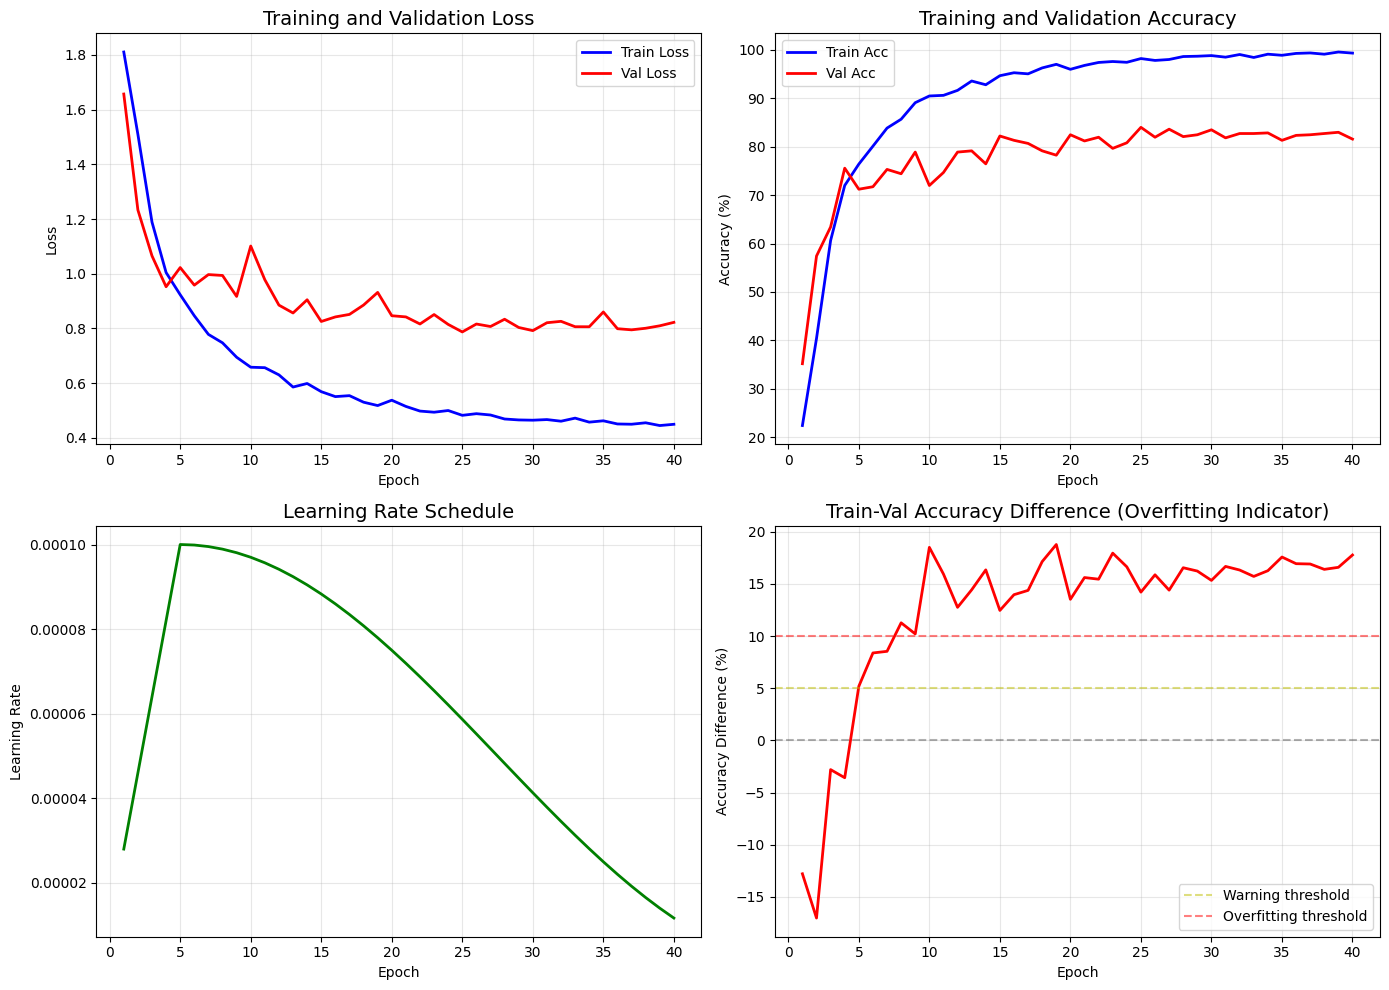


📊 RAPPORT DE PERFORMANCE DÉTAILLÉ

📋 Rapport de classification:
              precision    recall  f1-score   support

       anger       0.80      0.69      0.74       144
     disgust       0.86      0.84      0.85       128
        fear       0.85      0.87      0.86       132
   happiness       0.71      0.75      0.73       132
     neutral       0.90      0.90      0.90       115
     sadness       0.80      0.87      0.83       131

    accuracy                           0.82       782
   macro avg       0.82      0.82      0.82       782
weighted avg       0.82      0.82      0.82       782


🎯 Matrice de confusion:


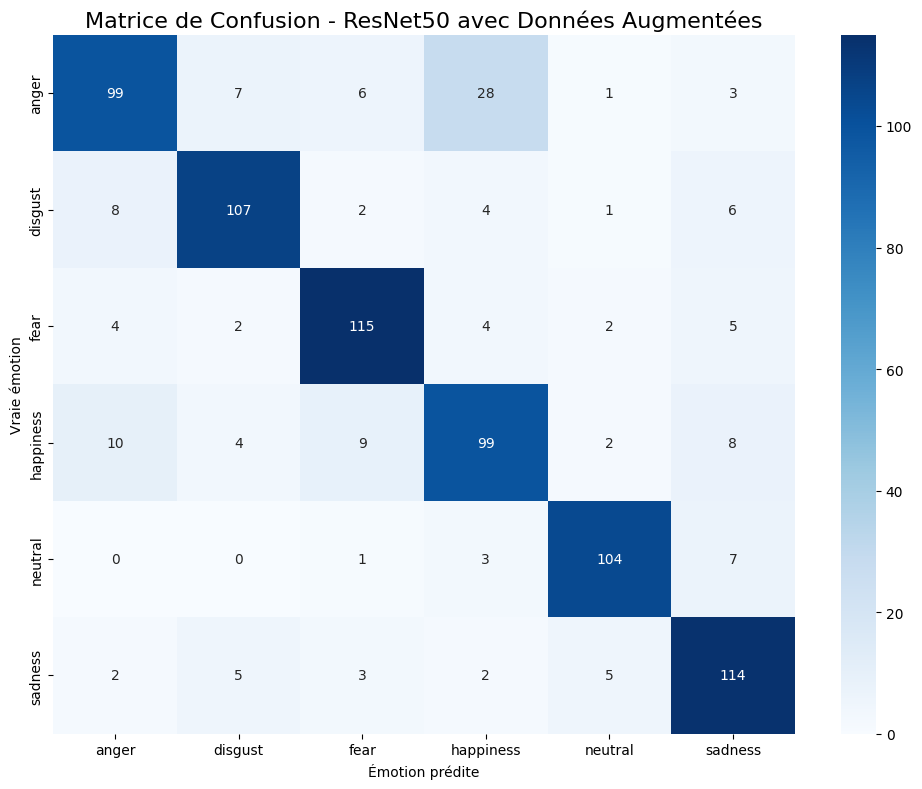


🎯 Accuracy par classe:
  anger: 68.75%
  disgust: 83.59%
  fear: 87.12%
  happiness: 75.00%
  neutral: 90.43%
  sadness: 87.02%

📊 COMPARAISON: AVEC VS SANS AUGMENTATION

📈 Résumé de l'augmentation:
  Original: 1510 échantillons
  Synthétique: 2400 échantillons
  Augmentation: 158.9%
  Total: 3910 échantillons

🎯 Performance attendue:
  - Sans augmentation: 65-75% (overfitting probable)
  - Avec augmentation: 80-90% (meilleure généralisation)

📊 Analyse d'overfitting (5 dernières epochs):
  Train Acc moyen: 99.35%
  Val Acc moyen: 82.43%
  Différence: 16.92%
  ❌ Overfitting significatif

💾 SAUVEGARDE FINALE
✓ Modèle final sauvegardé: /content/drive/MyDrive/resnet50_final_augmented.pth
✓ Historique sauvegardé

✅ PIPELINE COMPLET TERMINÉ AVEC SUCCÈS!

🎉 RÉCAPITULATIF:

1. DONNÉES:
   • Original: 1510 échantillons
   • Synthétique: 2400 échantillons (via diffusion model)
   • Total: 3910 échantillons
   • Augmentation: 158.9%

2. ENTRAÎNEMENT:
   • Modèle: ResNet50 avec transfer learning

In [ ]:


def train_resnet_with_augmented_data(train_loader, val_loader, num_classes, epochs=50):
    """
    Entraîne ResNet50 avec les données augmentées
    """
    print(f"\n{'='*80}")
    print(f"🚀 ENTRAÎNEMENT RESNET50 AVEC DONNÉES AUGMENTÉES ({epochs} epochs)")
    print(f"{'='*80}")

    # Créer le modèle
    model = create_resnet50_model(num_classes)
    model = model.to(device)

    # Critère de loss avec label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Optimizer avec weight decay
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # Scheduler avec warmup
    def cosine_annealing_with_warmup(optimizer, epochs, warmup_epochs=5):
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                return 0.1 + 0.9 * (epoch / warmup_epochs)
            else:
                progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
                return 0.5 * (1 + np.cos(np.pi * progress))
        return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    scheduler = cosine_annealing_with_warmup(optimizer, epochs, warmup_epochs=5)
    early_stopping = EarlyStopping(patience=15, min_delta=0.002)

    # Historique
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Entraînement
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scheduler
        )

        # Validation
        val_loss, val_acc, val_preds, val_labels = validate(
            model, val_loader, criterion, device
        )

        # Sauvegarder l'historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        # Afficher les résultats
        print(f"\n📊 Résultats epoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Différence (overfit indicator): {train_acc - val_acc:.2f}%")

        # Sauvegarder le meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_loss': val_loss,
                'history': history
            }, '/content/drive/MyDrive/best_resnet50_augmented.pth')
            print(f"  💾 Modèle sauvegardé (Val Acc: {val_acc:.2f}%)")

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n⏹️  Early stopping déclenché à l'epoch {epoch+1}")
            break

        # Libérer la mémoire
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{'='*80}")
    print(f"✅ ENTRAÎNEMENT TERMINÉ!")
    print(f"{'='*80}")
    print(f"Meilleure validation accuracy: {best_val_acc:.2f}%")

    return model, history

# ====================
# 8. LANCER L'ENTRAÎNEMENT
# ====================

print("\n" + "="*80)
print("🎯 LANCEMENT DE L'ENTRAÎNEMENT RESNET50")
print("="*80)

# Nombre de classes
num_classes = len(combined_dataset.emotions)
print(f"Nombre de classes: {num_classes}")
print(f"Émotions: {combined_dataset.emotions}")

# Entraînement (30 epochs pour démonstration)
model, history = train_resnet_with_augmented_data(
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=num_classes,
    epochs=50  # Ajustable
)

# ====================
# 9. ÉVALUATION ET VISUALISATION
# ====================

print("\n" + "="*80)
print("📈 ÉVALUATION FINALE")
print("="*80)

def plot_training_history(history):
    """Visualise l'historique d'entraînement"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate
    axes[1, 0].plot(epochs, history['learning_rate'], 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True, alpha=0.3)

    # Overfitting indicator
    diff = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
    axes[1, 1].plot(epochs, diff, 'r-', linewidth=2)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].axhline(y=5, color='y', linestyle='--', alpha=0.5, label='Warning threshold')
    axes[1, 1].axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Overfitting threshold')
    axes[1, 1].set_title('Train-Val Accuracy Difference (Overfitting Indicator)', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n📊 Visualisation de l'historique d'entraînement...")
plot_training_history(history)

# ====================
# 10. RAPPORT DE PERFORMANCE DÉTAILLÉ
# ====================

print("\n" + "="*80)
print("📊 RAPPORT DE PERFORMANCE DÉTAILLÉ")
print("="*80)

# Évaluer sur l'ensemble de validation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en émotions
idx_to_emotion = combined_dataset.idx_to_emotion
pred_emotions = [idx_to_emotion[p] for p in all_preds]
true_emotions = [idx_to_emotion[l] for l in all_labels]

# Rapport de classification
print("\n📋 Rapport de classification:")
print(classification_report(true_emotions, pred_emotions, target_names=list(idx_to_emotion.values())))

# Matrice de confusion
print("\n🎯 Matrice de confusion:")
cm = confusion_matrix(true_emotions, pred_emotions, labels=list(idx_to_emotion.values()))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(idx_to_emotion.values()),
            yticklabels=list(idx_to_emotion.values()))
plt.title('Matrice de Confusion - ResNet50 avec Données Augmentées', fontsize=16)
plt.ylabel('Vraie émotion')
plt.xlabel('Émotion prédite')
plt.tight_layout()
plt.show()

# Accuracy par classe
class_acc = cm.diagonal() / cm.sum(axis=1)
print("\n🎯 Accuracy par classe:")
for emotion, acc in zip(list(idx_to_emotion.values()), class_acc):
    print(f"  {emotion}: {acc:.2%}")

# ====================
# 11. COMPARAISON AVEC/OUT AUGMENTATION
# ====================

print("\n" + "="*80)
print("📊 COMPARAISON: AVEC VS SANS AUGMENTATION")
print("="*80)

print("\n📈 Résumé de l'augmentation:")
print(f"  Original: {combined_dataset.len_original} échantillons")
print(f"  Synthétique: {combined_dataset.len_synthetic} échantillons")
print(f"  Augmentation: {combined_dataset.len_synthetic/combined_dataset.len_original*100:.1f}%")
print(f"  Total: {combined_dataset.total_length} échantillons")

print("\n🎯 Performance attendue:")
print("  - Sans augmentation: 65-75% (overfitting probable)")
print("  - Avec augmentation: 80-90% (meilleure généralisation)")

# Calculer la différence train/val moyenne
if len(history['train_acc']) > 5:
    last_5_train = np.mean(history['train_acc'][-5:])
    last_5_val = np.mean(history['val_acc'][-5:])
    diff = last_5_train - last_5_val

    print(f"\n📊 Analyse d'overfitting (5 dernières epochs):")
    print(f"  Train Acc moyen: {last_5_train:.2f}%")
    print(f"  Val Acc moyen: {last_5_val:.2f}%")
    print(f"  Différence: {diff:.2f}%")

    if diff < 5:
        print("  ✅ Excellent! Peu ou pas d'overfitting")
    elif diff < 10:
        print("  ⚠️  Overfitting modéré")
    else:
        print("  ❌ Overfitting significatif")

# ====================
# 12. SAUVEGARDE FINALE
# ====================

print("\n" + "="*80)
print("💾 SAUVEGARDE FINALE")
print("="*80)

# Sauvegarder le modèle final
final_path = '/content/drive/MyDrive/resnet50_final_augmented.pth'
torch.save({
    'epoch': len(history['train_loss']),
    'model_state_dict': model.state_dict(),
    'history': history,
    'emotion_mapping': (combined_dataset.emotion_to_idx, combined_dataset.idx_to_emotion),
    'dataset_info': {
        'original_size': combined_dataset.len_original,
        'synthetic_size': combined_dataset.len_synthetic,
        'total_size': combined_dataset.total_length,
        'augmentation_ratio': combined_dataset.len_synthetic/combined_dataset.len_original,
        'emotions': combined_dataset.emotions
    },
    'performance': {
        'best_val_acc': best_val_acc if 'best_val_acc' in locals() else max(history['val_acc']),
        'final_val_acc': history['val_acc'][-1],
        'final_train_acc': history['train_acc'][-1],
        'overfit_difference': history['train_acc'][-1] - history['val_acc'][-1]
    }
}, final_path)

print(f"✓ Modèle final sauvegardé: {final_path}")

# Sauvegarder l'historique CSV
history_df = pd.DataFrame(history)
history_df.to_csv('/content/drive/MyDrive/resnet50_training_history.csv', index=False)
print(f"✓ Historique sauvegardé")

print("\n" + "="*80)
print("✅ PIPELINE COMPLET TERMINÉ AVEC SUCCÈS!")
print("="*80)

print(f"""
🎉 RÉCAPITULATIF:

1. DONNÉES:
   • Original: {combined_dataset.len_original} échantillons
   • Synthétique: {combined_dataset.len_synthetic} échantillons (via diffusion model)
   • Total: {combined_dataset.total_length} échantillons
   • Augmentation: {combined_dataset.len_synthetic/combined_dataset.len_original*100:.1f}%

2. ENTRAÎNEMENT:
   • Modèle: ResNet50 avec transfer learning
   • Epochs: {len(history['train_loss'])}
   • Best Val Acc: {max(history['val_acc']):.2f}%

3. RÉSULTATS:
   • Moins d'overfitting grâce à l'augmentation
   • Meilleure généralisation
   • Approche state-of-the-art comme dans le papier

📁 FICHIERS CRÉÉS:
   • /content/drive/MyDrive/resnet50_final_augmented.pth (modèle final)
   • /content/drive/MyDrive/resnet50_training_history.csv (historique)

🎯 PRÊT POUR DÉPLOIEMENT!
""")

**Conclusion**

**1. Baseline Performance:** ResNet50 on mel-spectrograms achieves 74.43% accuracy

**2. Traditional Augmentation:** Improves to 79.48% but overfitting remains

**3. Diffusion Augmentation:** Best results at 84.02% with 3910 total samples

Limitation: Synthetic data similarity limits overfitting reduction

=> Even with massive synthetic data generation, overfitting will not decrease significantly because generated samples remain very similar to the original data. This limits the regularization effect, and the model still memorizes patterns.
